In [1]:
# # Path to h5ad dataset
# dataset_path = '/work/vanaja_lab/griffin/projects/cshmm/results/pancreas_dev.h5ad'

# # Load and prepare AnnData
# if os.path.exists(dataset_path):
#     print("File exists. Loading the dataset...")
#     adata = sc.read_h5ad(dataset_path)
#     print("Dataset loaded successfully!")
#     print("Dataset shape:", adata.shape)
# else:
#     raise FileNotFoundError(f"File not found at: {dataset_path}")

# adata.obs_names_make_unique()

# # Preprocessing steps
# sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)

# # Min-max scaling
# scaler = MinMaxScaler()
# adata.X = scaler.fit_transform(adata.X.toarray())

# # HVG selection
# sc.pp.highly_variable_genes(adata, n_top_genes=5000, flavor='seurat')
# adata = adata[:, adata.var['highly_variable']].copy()

# print(f"Dataset shape after selecting top 1000 HVGs: {adata.shape}")


In [2]:
# #Dimensionality reduction and clustering
# sc.pp.pca(adata)
# sc.pp.neighbors(adata)
# sc.tl.umap(adata)
# sc.tl.leiden(adata, resolution=2, key_added="leiden")

# # Plot UMAP with clusters
# sc.pl.umap(adata, color="leiden", legend_loc="on data", title="UMAP - Leiden Clusters")

# # PAGA
# sc.tl.paga(adata, groups='leiden')
# sc.pl.paga(adata, color='leiden', title="PAGA Connectivity Graph")
# sc.pl.umap(adata, color=['leiden'], edges=True, title="UMAP with PAGA Connectivity")


In [3]:
#adata.write('data/mouse_panc_dev.h5ad')

In [4]:
import os
import scanpy as sc
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from models import TrajectoryGraph, initialize_trajectory


/work/vanaja_lab/griffin/miniconda3/envs/cellrank/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/work/vanaja_lab/griffin/miniconda3/envs/cellrank/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/work/vanaja_lab/griffin/miniconda3/envs/cellrank/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/work/vanaja_lab/griffin/miniconda3/envs/cellrank/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/work/vanaja_lab/griffin/miniconda3/envs/cellr

In [5]:
adata = sc.read('data/mouse_panc_dev.h5ad')

In [6]:
# Build the trajectory graph
traj_graph, cell_assignment = initialize_trajectory(
    adata=adata,
    random_state=41,
    debug=True
)


Trajectory graph nodes: ['leaf_0', 'split_1', 'leaf_2', 'leaf_3', 'leaf_4', 'split_5', 'root_split_6', 'leaf_7', 'leaf_8', 'split_9', 'leaf_10', 'split_11', 'split_12', 'split_13', 'int_14', 'split_15', 'leaf_16', 'leaf_17', 'RootNode_0_0']
Trajectory graph edges: [('split_1', 'split_9'), ('split_1', 'split_15'), ('split_5', 'leaf_7'), ('split_5', 'leaf_10'), ('root_split_6', 'split_1'), ('root_split_6', 'split_13'), ('split_9', 'leaf_3'), ('split_9', 'leaf_17'), ('split_11', 'split_12'), ('split_11', 'int_14'), ('split_12', 'leaf_2'), ('split_12', 'leaf_8'), ('split_13', 'split_5'), ('split_13', 'split_11'), ('int_14', 'leaf_4'), ('split_15', 'leaf_0'), ('split_15', 'leaf_16'), ('RootNode_0_0', 'root_split_6')]

Sample cell assignments (index-based):
                                 edge  latent_time
TAAGCGTAGGCCCGTT    (int_14, leaf_4)     0.773956
GACCAATAGTCGTCGT  (split_12, leaf_8)     0.438878
CGAGAAGCATGCTAGT    (int_14, leaf_4)     0.858598
ACGATGTAGGATTCCC    (int_14, leaf_4) 

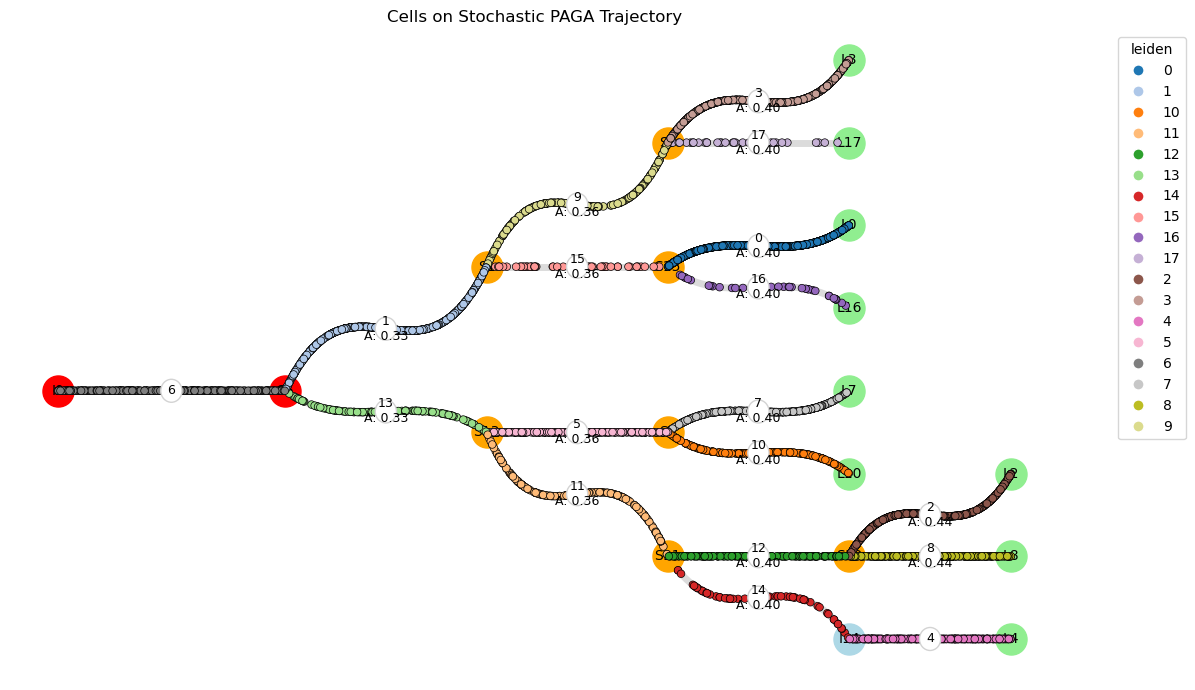

In [7]:
# Visualize trajectory graph with cells assigned
traj_graph.plot_cells_on_trajectory(
    cell_assignment=cell_assignment,
    color_key='leiden',
    curve_amount=0.8,
    node_size=500,
    cell_size=30,
    horizontal_thresh=0.01,
    edge_width=5,
    edge_color='lightgrey',
    title="Cells on Stochastic PAGA Trajectory",
    plot_transitions=True
)


In [8]:
# # === Imports ===

import torch
import numpy as np
from models.posterior import TreeVariationalPosterior
from models.belief import BeliefPropagator
from models.emission import pack_emission_params
from models.loss import compute_elbo
from utils.inference import initialize_beta_from_cell_assignment, find_path_index_for_edge

# # === Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Trajectory graph nodes: ['leaf_0', 'leaf_1', 'leaf_2', 'leaf_3', 'leaf_4', 'split_5', 'split_6', 'split_7', 'split_8', 'leaf_9', 'int_10', 'split_11', 'split_12', 'root_split_13', 'leaf_14', 'leaf_15', 'leaf_16', 'split_17', 'RootNode_0_0']
Trajectory graph edges: [('split_5', 'leaf_3'), ('split_5', 'int_10'), ('split_6', 'split_8'), ('split_6', 'split_17'), ('split_7', 'leaf_14'), ('split_7', 'leaf_15'), ('split_8', 'leaf_2'), ('split_8', 'leaf_9'), ('int_10', 'leaf_1'), ('split_11', 'split_5'), ('split_11', 'split_12'), ('split_12', 'leaf_0'), ('split_12', 'split_7'), ('root_split_13', 'split_6'), ('root_split_13', 'split_11'), ('split_17', 'leaf_4'), ('split_17', 'leaf_16'), ('RootNode_0_0', 'root_split_13')]

Sample cell assignments (index-based):
                                 edge  latent_time
TAAGCGTAGGCCCGTT  (split_17, leaf_4)     0.773956
GACCAATAGTCGTCGT  (split_6, split_8)     0.438878
CGAGAAGCATGCTAGT  (split_17, leaf_4)     0.858598
ACGATGTAGGATTCCC  (split_17, leaf_4) 

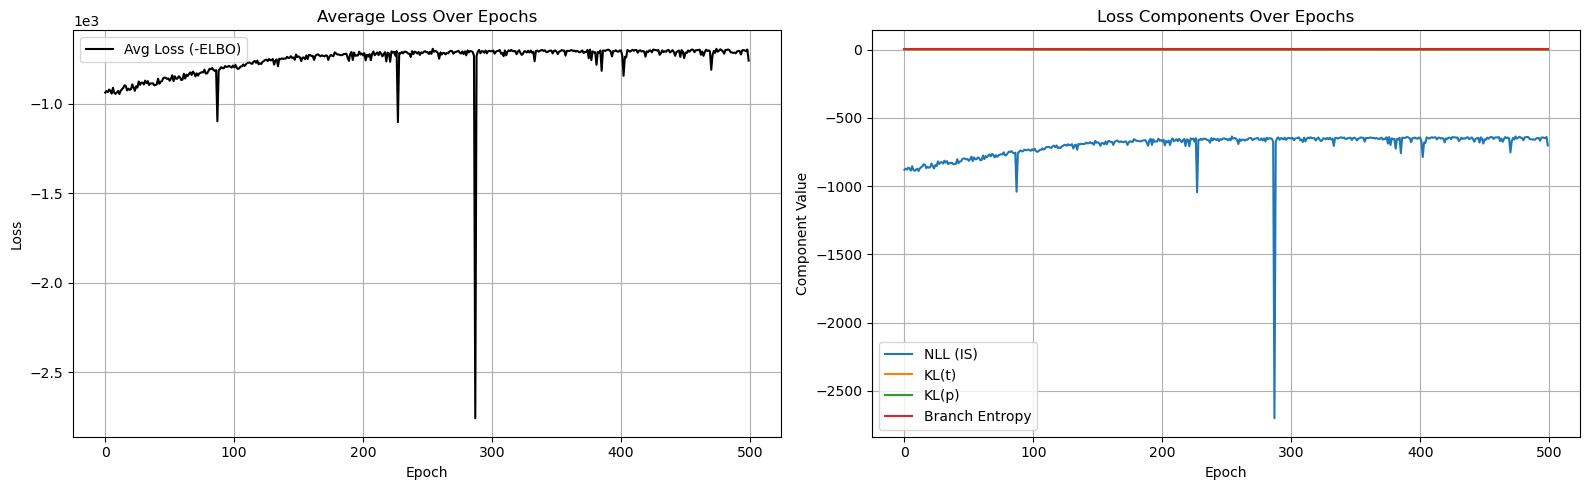

In [31]:
import torch
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'adata' is loaded and preprocessed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 1. Initialize Trajectory and Data ---
# (Make sure adata has 'leiden' clusters and PAGA computed)
# Example: sc.tl.leiden(adata); sc.tl.paga(adata, groups='leiden')
from models.trajectory import initialize_trajectory # Ensure this part works

# --- 2. Initialize Training Components ---
from training import initialize_training_components
# Step 1: Core data
X = torch.tensor(
    adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X,
    dtype=torch.float32,
    device=device
)
# 1. Trajectory setup
traj_graph, cell_assignment = initialize_trajectory(adata, debug=True)
traj_graph.initialize_emission_parameters(cell_assignment)

# 2. Posterior + BP
# Assume traj_graph and cell_assignment already defined
posterior = TreeVariationalPosterior(traj_graph, n_cells=X.shape[0], device=device)

# Use the updated versions of the functions you rewrote:
from utils.inference import (
    initialize_beta_from_cell_assignment,
    initialize_edge_logits_from_assignment
)

# Use internal mappings from traj_graph
edge_tuple_to_index = traj_graph.edge_tuple_to_index
node_to_index = traj_graph.node_to_index

# Initialize posterior parameters using the fixed functions
initialize_beta_from_cell_assignment(
    posterior, cell_assignment, edge_tuple_to_index, node_to_index, sharpness=0.01
)

initialize_edge_logits_from_assignment(
    posterior, cell_assignment, traj_graph, edge_tuple_to_index, high=5.0, low=0.0
)

# Confirm that initialization took effect
print("Alpha mean:", posterior.alpha.mean().item())
print("Beta mean:", posterior.beta.mean().item())
print("Logits mean:", posterior.edge_logits.mean().item())



belief_propagator = BeliefPropagator(traj_graph, posterior)
assert hasattr(belief_propagator, "diffuse"), "belief_propagator has been overwritten or is not initialized properly"

pi_init = None
# --- 3. Define Training Hyperparameters ---
config = {
    "training_mode": 'phase_switching',
    "use_pi": False,
    "num_epochs": 500,
    "batch_size": 2048,
    "lr": 0.01,
    # --- Curriculum / Mode specific ---
    "freeze_posterior_epochs": 0,  # Immediate posterior updates
    "inference_steps": 1,
    "generative_steps": 3,
    "phase_epochs_inf": 8,
    "phase_epochs_gen": 8,
    # --- ELBO / Loss ---
    "n_samples": 10,
    "kl_weight": 0.00,               # Weak KL to encourage exploration
    "kl_p_weight": 0.00,             # Same for prior
    "t_cont_weight": 0.0,
    "transition_weight": 1.0,
    "l1_weight": 1.0,
    "branch_entropy_weight": 10.0,   # Force edge assignment entropy
    # --- Tau Annealing ---
    "tau_start": 8.0,
    "tau_end": 1.0,
    "tau_anneal_mode": 'exponential',
    "tau_anneal_rate": 0.05,
    # --- Proposal Distribution ---
    "proposal_edge_temp": 10.0,         # Flatten q(edge)
    "proposal_diffusion_alpha": 0.9,   # Stronger smoothing
    "proposal_diffusion_steps": 4,
    # --- Device / Extras ---
    "device": device,
    "gradient_clip_norm": 1.0
}




# --- 4. Run Training ---
from training.loop import train_model

if config["use_pi"] and pi_init is None:
     print("Warning: config['use_pi'] is True, but pi_init is None. Initializing pi internally or expecting it.")

print("belief_propagator type:", type(belief_propagator))
assert hasattr(belief_propagator, "diffuse"), "belief_propagator was overwritten."

# Run the training
trained_posterior, g, K, sigma2, pi, log_history = train_model(
    X=X,
    traj_graph=traj_graph,
    posterior=posterior,
    belief_propagator=belief_propagator,
    pi_init=pi_init,
    edge_tuple_to_index={(u, v): i for i, (u, v) in enumerate(traj_graph.edge_list)},
    **config
)

# --- 5. Post-Training Analysis (Example) ---
print("\n--- Final Parameters ---")
print(f"Final g mean: {g.mean().item():.3f}")
print(f"Final K mean: {K.mean().item():.3f}") # K_final is Parameter, use .data if needed elsewhere
print(f"Final sigma2 mean: {sigma2.mean().item():.3f}")
if config["use_pi"] and pi_final is not None:
    print(f"Final pi mean: {pi.mean().item():.3f}") # pi_final is Parameter

# --- 6. Plotting ---
print("Generating plots...")

# <<< START MODIFIED CODE: Assign logs to expected variable names >>>
loss_log = log_history["loss"]             # Use the correct key for total loss
nll_log = log_history["nll_weighted"]      # Use the correct key for NLL component
kl_t_log = log_history["kl_t"]
kl_p_log = log_history["kl_p"]
branch_entropy_log = log_history["branch_entropy"] # Get this if needed
# The following logs don't exist in the history anymore:
# t_cont_log, transition_log, l1_log

# Ensure logs are not empty before plotting
if not loss_log: # Check the main loss log
    print("Warning: Log history is empty. Skipping plotting.")
else:
    epochs = range(len(loss_log))

    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # === Loss plot ===  (Changed from ELBO)
    axes[0].plot(epochs, loss_log, label="Avg Loss (-ELBO)", color="black")
    axes[0].set_title("Average Loss Over Epochs")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    axes[0].grid(True)
    axes[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    # === Component losses ===
    # Plot components that are actually logged
    axes[1].plot(epochs, nll_log, label="NLL (IS)") # Updated label
    axes[1].plot(epochs, kl_t_log, label="KL(t)")
    axes[1].plot(epochs, kl_p_log, label="KL(p)")
    # Only plot branch entropy if weight > 0 and it exists
    if config["branch_entropy_weight"] > 0 and "branch_entropy" in log_history:
         axes[1].plot(epochs, branch_entropy_log, label="Branch Entropy")

    # --- Removed plots for t_cont, transition, l1 ---

    axes[1].set_title("Loss Components Over Epochs")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Component Value")
    # axes[1].set_yscale('symlog') # Use symlog if scales vary wildly
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

In [30]:
print(posterior.edge_logits.grad.norm())

tensor(5.3621e-05, device='cuda:0')


In [32]:
#index_to_edge = {v: k for k, v in edge_to_index.items()}
def extract_fitted_betas_by_argmax(posterior, index_to_edge, adata):
    """
    Extract learned beta distribution parameters using the MAP edge assignment per cell.

    Args:
        posterior: Trained posterior object with `alpha` and `beta` of shape [cells x edges].
        index_to_edge: Dict mapping edge indices (int) to edge (u_idx, v_idx) tuples.
        adata: AnnData object for extracting cell IDs.

    Returns:
        pd.DataFrame: Indexed by cell ID with columns 'edge', 'alpha', and 'beta'.
    """
    alpha = posterior.alpha.detach().cpu().numpy()
    beta = posterior.beta.detach().cpu().numpy()
    max_idx = (alpha + beta - 2).argmax(axis=1)  # MAP estimate of mean

    records = []
    for i, edge_idx in enumerate(max_idx):
        edge = index_to_edge[edge_idx]
        records.append({
            "cell_id": adata.obs_names[i],
            "edge": tuple(edge),  # ensure tuple format
            "alpha": alpha[i, edge_idx],
            "beta": beta[i, edge_idx],
        })

    return pd.DataFrame(records).set_index("cell_id")

fitted_betas = extract_fitted_betas_by_argmax(posterior, posterior.index_to_edge, adata)
fitted_betas["edge"] = fitted_betas["edge"].apply(lambda x: tuple(x) if not isinstance(x, tuple) else x)
fitted_betas

,edge,alpha,beta
cell_id,,,
TAAGCGTAGGCCCGTT,"(17, 4)",24.259918,75.599762
GACCAATAGTCGTCGT,"(6, 8)",54.325897,42.274876
CGAGAAGCATGCTAGT,"(17, 4)",15.985847,84.004158
ACGATGTAGGATTCCC,"(17, 4)",31.385191,67.935867
GCAGTTAAGGTCATCT,"(17, 4)",88.742592,11.252789
...,...,...,...
GGAGCAAGTCTAGTGT,"(18, 13)",53.678780,42.947716
TTTACTGTCAGTTCGG,"(11, 12)",97.539154,1.736142
GAAATGAGTCGGCACT,"(11, 12)",40.981342,55.650043


In [33]:
print("Posterior Alpha Stats:\n", pd.Series(posterior.alpha.detach().cpu().numpy().flatten()).describe())
print("\nPosterior Beta Stats:\n", pd.Series(posterior.beta.detach().cpu().numpy().flatten()).describe())
print("\nPosterior Edge Logits Stats:\n", pd.Series(posterior.edge_logits.detach().cpu().numpy().flatten()).describe())

# Check alpha vs beta for a few cells' max edge
with torch.no_grad():
    idx_to_check = torch.tensor([0, 10, 100]) # Example cell indices
    q_probs_check = torch.softmax(posterior.edge_logits[idx_to_check], dim=1)
    max_prob_check, edge_idx_max_check = torch.max(q_probs_check, dim=1)
    alpha_max_check = posterior.alpha[idx_to_check, edge_idx_max_check]
    beta_max_check = posterior.beta[idx_to_check, edge_idx_max_check]
    print("\nSample Alpha/Beta for Max Edge:")
    for i in range(len(idx_to_check)):
        print(f"  Cell {idx_to_check[i]}: EdgeIdx={edge_idx_max_check[i].item()}, Prob={max_prob_check[i]:.3f}, Alpha={alpha_max_check[i]:.3f}, Beta={beta_max_check[i]:.3f}")

print(f"\nNumber of Edges: {posterior.n_edges}")
print(f"Approx Uniform Prob: {1.0/posterior.n_edges:.3f}")

Posterior Alpha Stats:
 count    98172.000000
mean         3.716850
std         12.939819
min          0.585061
25%          1.000000
50%          1.000000
75%          1.000000
max         98.066299
dtype: float64

Posterior Beta Stats:
 count    98172.000000
mean         3.660508
std         12.736458
min          0.571141
25%          1.000000
50%          1.000000
75%          1.000000
max         98.065628
dtype: float64

Posterior Edge Logits Stats:
 count    98172.000000
mean         2.266846
std          0.110423
min          2.212941
25%          2.235987
50%          2.240505
75%          2.245494
max          2.752047
dtype: float64

Sample Alpha/Beta for Max Edge:
  Cell 0: EdgeIdx=15, Prob=0.087, Alpha=24.260, Beta=75.600
  Cell 10: EdgeIdx=12, Prob=0.087, Alpha=61.124, Beta=35.898
  Cell 100: EdgeIdx=15, Prob=0.086, Alpha=10.999, Beta=89.003

Number of Edges: 18
Approx Uniform Prob: 0.056


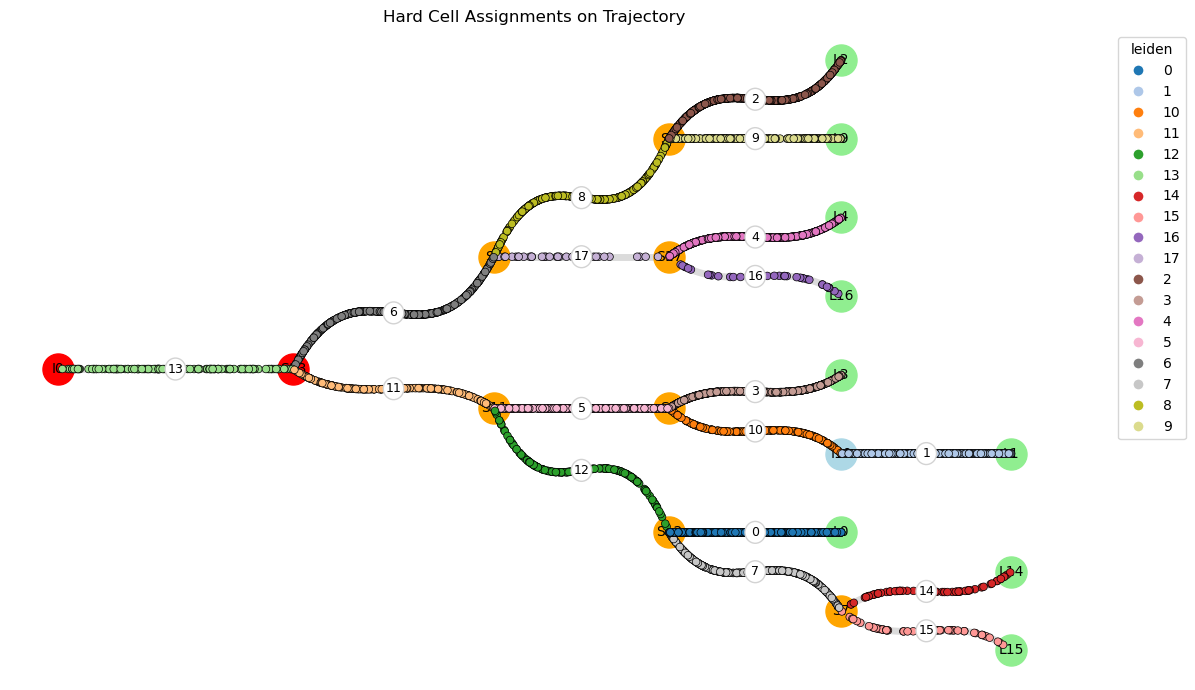

In [34]:
from viz.trajectory import plot_cells_on_trajectory

plot_cells_on_trajectory(
    traj_graph,
    cell_assignment,
    adata,
    color_key="leiden",  # or any other obs key
    curve_amount=0.8,
    title="Hard Cell Assignments on Trajectory"
)


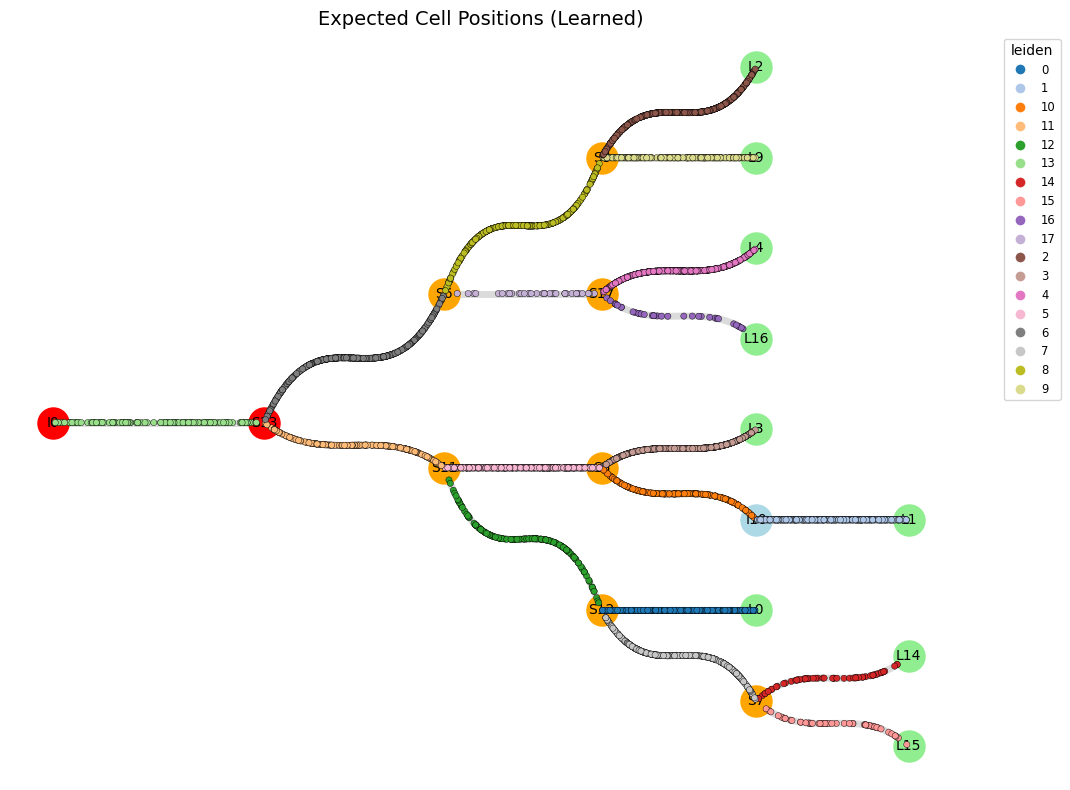

In [35]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import networkx as nx
import os # For checking savepath directory

# --- Import ACTUAL helper functions ---
# Assuming your notebook's working directory or Python path allows access 
# to the 'utils' and 'viz' directories from your project structure.
from utils.math import cubic_bezier
from viz.trajectory import (
    compute_graph_layout, 
    draw_graph_base,        # This uses compute_bezier_control_points internally
    get_cell_color_map, 
    compute_bezier_control_points # Explicitly needed for cell positioning on curves
)
# Import needed classes for type hinting (optional but good practice)
from models.posterior import TreeVariationalPosterior 
from models.trajectory import TrajectoryGraph # Assuming this is the class for traj_graph
from anndata import AnnData # For type hinting adata


def plot_expected_cell_positions_on_trajectory(
    posterior: TreeVariationalPosterior, # Trained posterior object
    traj_graph: TrajectoryGraph,         # TrajectoryGraph object
    adata: AnnData,                      # AnnData object
    color_key: str = 'leiden',           # Key in adata.obs or adata.var_names for coloring
    node_size: int = 500,
    cell_size: int = 30,
    edge_width: int = 5,
    edge_color: str = 'lightgrey',
    curve_amount: float = 0.8,           # How much edges should curve (0 = straight)
    title: str = "Expected Cell Positions on Trajectory",
    savepath: str | None = None,         # Optional path to save the figure
    eps: float = 1e-6                    # Small epsilon for numerical stability
):
    """
    Visualizes the expected position of each cell on the trajectory graph.

    The expected position is determined by the most probable edge assignment
    and the expected latent time (mean of the Beta distribution) along that edge,
    derived from the trained posterior. Cells are colored by metadata.
    Uses helper functions imported from the project structure.

    Args:
        posterior: Trained posterior model.
        traj_graph: Trajectory structure, expected to have a G_traj attribute.
        adata: Annotated data matrix for cell coloring.
        color_key: Key for coloring cells.
        node_size: Size of graph nodes.
        cell_size: Size of cell markers.
        edge_width: Width of graph edges.
        edge_color: Color of graph edges.
        curve_amount: Edge curvature intensity.
        title: Plot title.
        savepath: Optional path to save the plot. Defaults to None.
        eps: Small value for numerical stability.
    """
    # --- Input Validation ---
    if not isinstance(posterior, TreeVariationalPosterior):
         raise TypeError("`posterior` must be an instance of TreeVariationalPosterior")
    if not hasattr(traj_graph, 'G_traj'):
         raise ValueError("`traj_graph` must have a `G_traj` attribute (NetworkX graph)")
    if not isinstance(adata, AnnData):
         raise TypeError("`adata` must be an instance of AnnData")
         
    G_traj_nx = traj_graph.G_traj # Get the underlying NetworkX graph
    if not isinstance(G_traj_nx, nx.DiGraph):
        raise TypeError("`traj_graph.G_traj` must be a NetworkX DiGraph")
        
    device = posterior.device
    n_cells = posterior.n_cells
    if n_cells != adata.n_obs:
         # Use min to be safe if adata has more cells than posterior was trained on
         n_cells_to_plot = min(n_cells, adata.n_obs)
         print(f"Warning: Posterior n_cells ({n_cells}) differs from adata.n_obs ({adata.n_obs}). Plotting {n_cells_to_plot} cells.")
         cell_ids_ordered = adata.obs_names[:n_cells_to_plot] 
    else:
        n_cells_to_plot = n_cells
        cell_ids_ordered = adata.obs_names # Assume order matches posterior

    # --- 1. Calculate Expected Positions ---
    with torch.no_grad():
        # Get edge probabilities: q(edge | cell) for the cells we can plot
        edge_logits = posterior.edge_logits[:n_cells_to_plot, :].detach()
        q_edge_probs = torch.softmax(edge_logits, dim=1) # [n_cells_plot, n_edges]

        # Find the most probable edge index for each cell
        edge_idx_max = torch.argmax(q_edge_probs, dim=1) # [n_cells_plot]

        # Get alpha and beta parameters for the most probable edge
        alpha_all = posterior.alpha[:n_cells_to_plot, :].detach() # [n_cells_plot, n_edges]
        beta_all = posterior.beta[:n_cells_to_plot, :].detach()   # [n_cells_plot, n_edges]

        # Gather alpha and beta for the most probable edge for each cell
        cell_indices = torch.arange(n_cells_to_plot, device=device)
        alpha_max = alpha_all[cell_indices, edge_idx_max] # [n_cells_plot]
        beta_max = beta_all[cell_indices, edge_idx_max]   # [n_cells_plot]

        # Calculate expected time t = alpha / (alpha + beta) for the most probable edge
        expected_t = alpha_max / (alpha_max + beta_max + eps)
        expected_t = expected_t.clamp(0.0, 1.0) # Ensure t is within [0, 1]

        # Move results to CPU for easier iteration and plotting
        edge_idx_max_np = edge_idx_max.cpu().numpy()
        expected_t_np = expected_t.cpu().numpy()

    # --- 2. Prepare for Plotting ---
    pos = compute_graph_layout(G_traj_nx) # Calculate node positions using imported function

    plt.figure(figsize=(12, 8)) # Adjust figure size as needed
    ax = plt.gca()

    # Draw the base graph (nodes and edges) using imported function
    # It internally uses compute_bezier_control_points
    draw_graph_base(
        G_traj_nx, pos,
        node_size=node_size,
        edge_width=edge_width,
        edge_color=edge_color,
        curve_amount=curve_amount
        # Note: `horizontal_thresh` is an argument to the original draw_graph_base,
        # we can add it back if needed, using its default 0.01
    )

    # Get cell coloring information using imported function
    try:
        cell_color_values, get_color_func, is_continuous, color_map_obj, norm_obj = get_cell_color_map(adata, color_key)
    except ValueError as e:
        print(f"Error getting cell colors: {e}")
        return # Abort plotting if color key is invalid

    # --- 3. Plot Cells at Expected Positions ---
    cell_x_coords = []
    cell_y_coords = []
    cell_plot_colors = []
    
    plotted_cell_count = 0
    skipped_cells = 0

    for i in range(n_cells_to_plot):
        cell_id = cell_ids_ordered[i]
        max_edge_idx = edge_idx_max_np[i]
        t = expected_t_np[i]

        # Map edge index back to node names using posterior's mappings
        try:
            # Ensure mappings exist in the posterior object
            if not hasattr(posterior, 'index_to_edge') or not hasattr(posterior, 'index_to_name'):
                 raise AttributeError("Posterior object missing 'index_to_edge' or 'index_to_name' mapping.")
            u_idx, v_idx = posterior.index_to_edge[max_edge_idx]
            u_name = posterior.index_to_name[u_idx]
            v_name = posterior.index_to_name[v_idx]
        except (KeyError, AttributeError) as e:
            # print(f"Debug: Error mapping edge index {max_edge_idx} for cell {i} (ID: {cell_id}). Error: {e}")
            skipped_cells += 1
            continue

        # Get positions of the start and end nodes of the most likely edge
        if u_name not in pos or v_name not in pos:
             # print(f"Debug: Missing position for node {u_name} or {v_name}. Skipping cell {i} (ID: {cell_id}).")
             skipped_cells += 1
             continue
             
        P0 = np.array(pos[u_name])
        P1 = np.array(pos[v_name])

        # Calculate the coordinates on the (potentially curved) edge
        # Check if edge is effectively straight or curve_amount is zero
        if np.allclose(P0, P1) or curve_amount == 0.0:
            # Straight line interpolation
            pt = P0 + t * (P1 - P0)
        else:
            # Bézier curve interpolation using imported helpers
            cp1, cp2 = compute_bezier_control_points(P0, P1, curve_amount)
            # Pass t as a NumPy array to imported cubic_bezier
            pt = cubic_bezier(P0, cp1, cp2, P1, np.array([t]))[0] # Get the single point

        cell_x_coords.append(pt[0])
        cell_y_coords.append(pt[1])

        # Get the color for this cell
        try:
             # Ensure cell_id exists in the index used for coloring
             if cell_id not in cell_color_values.index:
                 raise KeyError(f"Cell ID {cell_id} not found in coloring data.")
             color_val = cell_color_values.loc[cell_id]
             # Handle if color_val is Series (e.g., from adata.var_names used as key)
             color_val = color_val.iloc[0] if isinstance(color_val, pd.Series) else color_val
             plot_color = get_color_func(color_val)
             cell_plot_colors.append(plot_color)
        except KeyError:
             # print(f"Debug: Cell ID {cell_id} not found in AnnData for coloring. Using default color.")
             cell_plot_colors.append('gray') # Default color for missing cells
             # Note: This case might indicate inconsistency between adata and posterior cell order/set
        
        plotted_cell_count += 1

    if skipped_cells > 0:
        print(f"Warning: Skipped plotting {skipped_cells} cells due to mapping or position errors.")
    if plotted_cell_count == 0:
        print("Error: No cells were plotted. Check posterior mappings and graph layout.")
        plt.close() # Close empty figure
        return

    # Scatter plot the cells
    ax.scatter(
        cell_x_coords, cell_y_coords,
        color=cell_plot_colors,
        s=cell_size,
        edgecolor='black', # Add slight edge for visibility
        linewidth=0.3,
        zorder=5 # Ensure cells are plotted on top of edges
    )

    # --- 4. Add Legend and Final Touches ---
    if is_continuous:
        # Add colorbar for continuous data
        sm = cm.ScalarMappable(cmap=color_map_obj, norm=norm_obj)
        sm.set_array([]) # Necessary workaround for colorbar
        try:
            cbar = plt.colorbar(sm, ax=ax, shrink=0.7)
            cbar.set_label(color_key, rotation=270, labelpad=15)
        except Exception as e:
             print(f"Warning: Could not create colorbar. Error: {e}")
    else:
        # Add legend for categorical data
        try:
             # Make sure color_map_obj is a dict {category: color}
             if isinstance(color_map_obj, dict):
                 # Filter categories that actually appear in the plotted data if possible
                 # For simplicity here, we use all categories from the map
                 valid_cats = sorted([cat for cat in color_map_obj.keys() if not pd.isna(cat)]) # Exclude NaN if present
                 handles = [plt.Line2D([0], [0], marker='o', color='w', label=str(cat),
                                      markerfacecolor=color_map_obj[cat], markersize=8)
                           for cat in valid_cats]
                 if handles:
                     ax.legend(handles=handles, title=color_key, bbox_to_anchor=(1.05, 1), 
                               loc='upper left', title_fontsize='medium', fontsize='small')
                 else:
                      print("Warning: No valid categories found for legend.")
             else:
                 print("Warning: Could not create categorical legend (color_map_obj is not a dict).")
        except Exception as e:
            print(f"Warning: Could not create legend. Error: {e}")


    plt.title(title, fontsize=14)
    plt.axis("off")
    # Adjust layout more robustly to prevent legend/colorbar overlap
    plt.tight_layout(rect=[0, 0, 0.9, 1]) 

    # --- 5. Save Figure ---
    if savepath:
        try:
            # Ensure directory exists
            save_dir = os.path.dirname(savepath)
            if save_dir and not os.path.exists(save_dir):
                os.makedirs(save_dir)
            
            ext = os.path.splitext(savepath)[1].lower()
            valid_exts = [".png", ".pdf", ".svg", ".jpg", ".jpeg", ".tiff"]
            if not ext or ext not in valid_exts:
                 print(f"Warning: File extension '{ext}' invalid or missing. Saving as PNG.")
                 savepath = os.path.splitext(savepath)[0] + ".png"

            plt.savefig(savepath, dpi=300, bbox_inches='tight')
            print(f"Plot saved to: {savepath}")
        except Exception as e:
            print(f"Error saving plot to {savepath}: {e}")

    plt.show()



# Example Usage (in a Jupyter Notebook cell after training):
# Assume 'posterior', 'traj_graph', and 'adata' are available from training

plot_expected_cell_positions_on_trajectory(
    posterior=trained_posterior,
    traj_graph=traj_graph,
    adata=adata,
    color_key='leiden',
    node_size=500,
    cell_size=20,
    edge_width=5,
    edge_color='lightgrey',
    curve_amount=0.7,
    title="Expected Cell Positions (Learned)",
#    savepath="./plots/expected_positions_leiden.png"
)


Plotting for cell indices: [594, 187, 3229]

Cell ACAGCCGTCACCGGGT (Index 594):
  Most likely edge index: 7
  Expected time on edge 7: 0.980
  Baseline NLL at (7, 0.980): -687.91


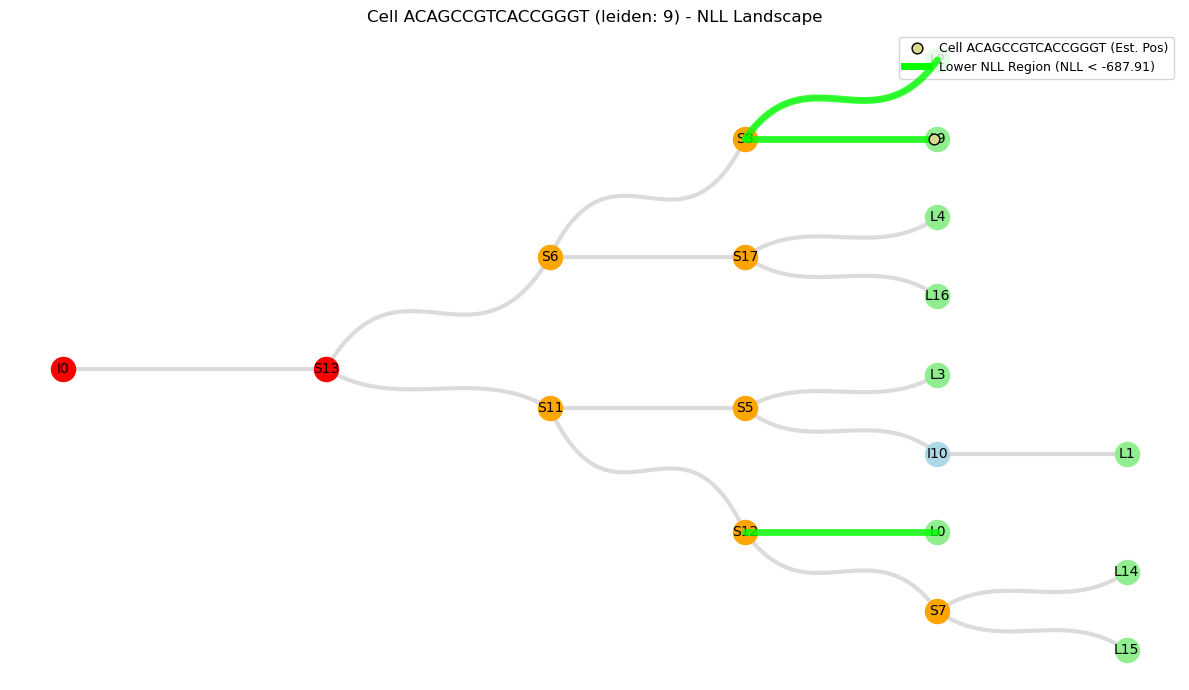


Cell AGGGAGTTCGGAAACG (Index 187):
  Most likely edge index: 15
  Expected time on edge 15: 0.887
  Baseline NLL at (15, 0.887): -752.54


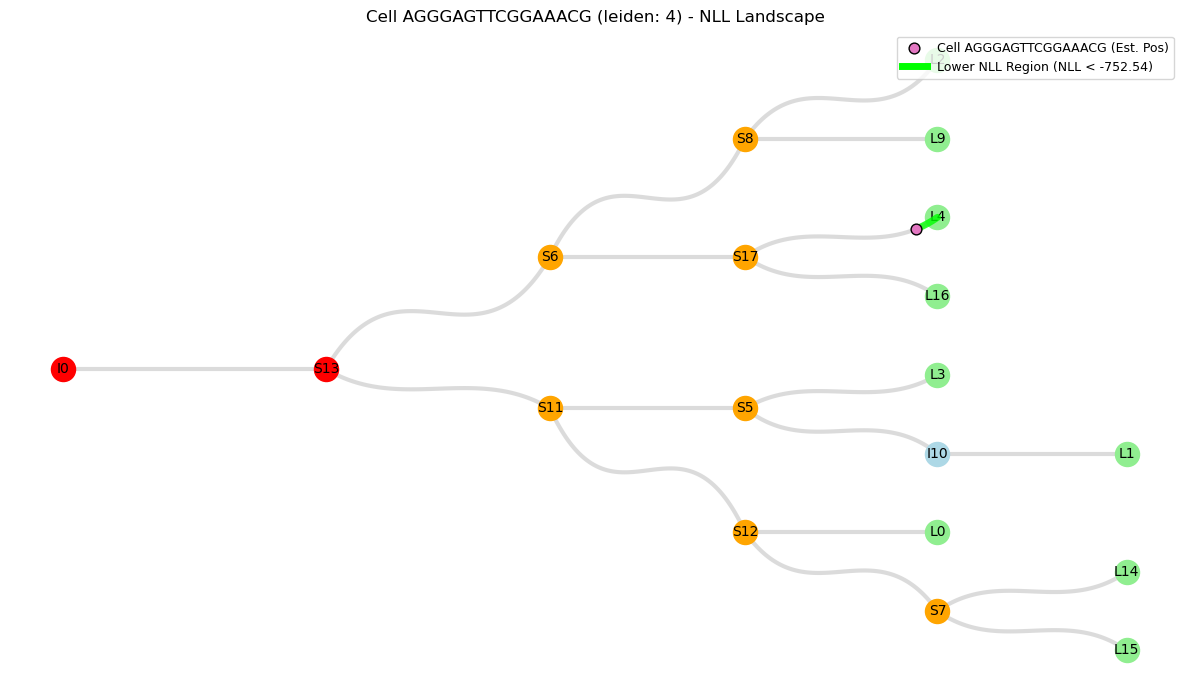


Cell GCTGGGTGTAGAGGAA (Index 3229):
  Most likely edge index: 8
  Expected time on edge 8: 0.517
  Baseline NLL at (8, 0.517): -646.15


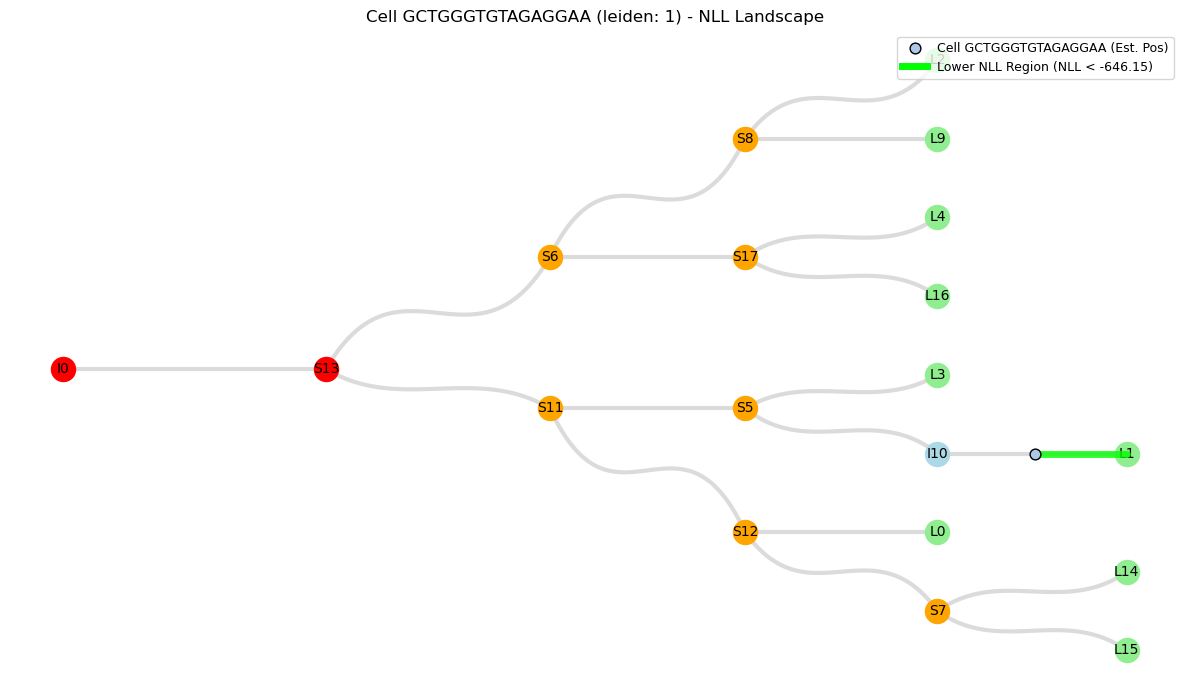


Finished plotting.


In [36]:
# %% Imports (ensure these are run)
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import networkx as nx
import random

# Import necessary functions from your project structure
from models.emission import emission_nll
from viz.trajectory import (
    compute_graph_layout,
    draw_graph_base,
    compute_bezier_control_points,
    get_cell_color_map,
)
from utils.constants import EPSILON
from utils.math import cubic_bezier # Assuming this is available

# --- Ensure Required Variables Exist (from your training script) ---
# trained_posterior, g, K, sigma2, pi, X, traj_graph, adata, config
# Example check (replace with your actual variables):
assert 'trained_posterior' in locals(), "trained_posterior not found. Run training first."
assert 'g' in locals(), "g not found. Run training first."
assert 'K' in locals(), "K not found. Run training first."
assert 'sigma2' in locals(), "sigma2 not found. Run training first."
# pi might be None if use_pi=False
# assert 'pi' in locals(), "pi not found. Run training first."
assert 'X' in locals(), "X not found. Run training first."
assert 'traj_graph' in locals(), "traj_graph not found. Run training first."
assert 'adata' in locals(), "adata not found. Run training first."
assert 'config' in locals(), "config not found. Run training first."

# --- Helper Function for NLL Calculation ---
@torch.no_grad()
def calculate_nll_for_cell_assignment(
    cell_x_vector, # Single cell expression [G]
    edge_idx,      # Scalar edge index
    time_val,      # Scalar time value (0-1)
    g_param, K_param, sigma2_param, pi_param, # Learned generative parameters
    posterior_model, # Needed for index_to_edge mapping
    traj_graph_model, # Needed for node_to_index mapping
    device='cpu'
):
    """Calculates NLL for a single cell at a specific edge and time."""
    # Prepare inputs for emission_nll (needs batch dimension)
    X_batch = cell_x_vector.unsqueeze(0).to(device) # [1, G]
    P_idx_batch = torch.tensor([edge_idx], dtype=torch.long, device=device) # [1]
    T_batch = torch.tensor([time_val], dtype=torch.float32, device=device) # [1]

    # Use the mappings from the posterior and traj_graph objects
    index_to_edge_map = posterior_model.index_to_edge
    node_to_index_map = traj_graph_model.node_to_index

    # Ensure parameters are on the correct device
    g_param = g_param.to(device)
    K_param = K_param.to(device)
    sigma2_param = sigma2_param.to(device)
    if pi_param is not None:
        pi_param = pi_param.to(device)

    nll_per_cell = emission_nll(
        X=X_batch,
        P_idx=P_idx_batch,
        T=T_batch,
        g=g_param,
        K=K_param,
        sigma2_param=sigma2_param,
        index_to_edge=index_to_edge_map,
        node_to_index=node_to_index_map,
        pi=pi_param,
        eps=EPSILON,
        log_eps=1e-8 # Use appropriate log epsilon
    )
    return nll_per_cell.item() # Return scalar NLL value


# --- Plotting Parameters ---
N_CELLS_TO_PLOT = 3
N_TIME_POINTS = 50 # Resolution for checking NLL along edges
COLOR_KEY = 'leiden' # Key in adata.obs for cell coloring
NODE_SIZE = 300
CELL_MARKER_SIZE = 60
EDGE_WIDTH = 3
EDGE_COLOR = 'lightgrey'
CURVE_AMOUNT = 0.8
HIGHLIGHT_COLOR = 'lime' #'#00FF00' # Bright green
HIGHLIGHT_WIDTH = EDGE_WIDTH + 2
HIGHLIGHT_ALPHA = 0.8
DEVICE = config.get('device', torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# --- Data Preparation ---
trained_posterior.eval() # Set posterior to evaluation mode
X = X.to(DEVICE)
g = g.to(DEVICE)
K = K.to(DEVICE)
sigma2 = sigma2.to(DEVICE)
if pi is not None:
    pi = pi.to(DEVICE)

n_cells = X.shape[0]
n_edges = trained_posterior.n_edges

# Get mappings
index_to_edge = trained_posterior.index_to_edge # {edge_idx: (u_idx, v_idx)}
node_to_index = traj_graph.node_to_index       # {node_name: node_idx}
index_to_node = {v: k for k, v in node_to_index.items()} # {node_idx: node_name}

# Choose random cells
random_cell_indices = random.sample(range(n_cells), N_CELLS_TO_PLOT)
print(f"Plotting for cell indices: {random_cell_indices}")

# Get cell colors
cell_colors_raw, get_color_func, is_continuous, color_map_info, norm = get_cell_color_map(adata, COLOR_KEY)

# Precompute graph layout
pos = compute_graph_layout(traj_graph.G_traj) # Use the nx graph inside traj_graph

# --- Generate Plots ---
for i, cell_idx in enumerate(random_cell_indices):
    cell_id = adata.obs_names[cell_idx]
    X_cell = X[cell_idx] # Shape [G]

    # --- 1. Calculate Current Expected/Most Likely Position & Baseline NLL ---
    with torch.no_grad():
        # Posterior edge probabilities for the cell
        edge_logits_cell = trained_posterior.edge_logits[cell_idx]
        q_edge_probs_cell = torch.softmax(edge_logits_cell, dim=0) # Shape [E]

        # Most likely edge
        e_star_idx = q_edge_probs_cell.argmax().item()

        # Expected time for the *most likely* edge
        alpha_cell_star = trained_posterior.alpha.data[cell_idx, e_star_idx].clamp(min=EPSILON)
        beta_cell_star = trained_posterior.beta.data[cell_idx, e_star_idx].clamp(min=EPSILON)
        t_star_expected = alpha_cell_star / (alpha_cell_star + beta_cell_star)
        t_star_expected = t_star_expected.item() # Scalar expected time for the most likely edge

    # Calculate baseline NLL at this most likely assignment
    baseline_nll = calculate_nll_for_cell_assignment(
        X_cell, e_star_idx, t_star_expected,
        g, K, sigma2, pi,
        trained_posterior, traj_graph, device=DEVICE
    )
    print(f"\nCell {cell_id} (Index {cell_idx}):")
    print(f"  Most likely edge index: {e_star_idx}")
    print(f"  Expected time on edge {e_star_idx}: {t_star_expected:.3f}")
    print(f"  Baseline NLL at ({e_star_idx}, {t_star_expected:.3f}): {baseline_nll:.2f}")

    # --- 2. Evaluate NLL across all edges and times ---
    time_grid = torch.linspace(EPSILON, 1.0 - EPSILON, N_TIME_POINTS, device=DEVICE)
    better_nll_segments = {} # {edge_idx: [(t_start, t_end), ...]}

    for edge_idx_eval in range(n_edges):
        nll_values_on_edge = []
        for t_eval in time_grid:
            nll = calculate_nll_for_cell_assignment(
                X_cell, edge_idx_eval, t_eval.item(),
                g, K, sigma2, pi,
                trained_posterior, traj_graph, device=DEVICE
            )
            nll_values_on_edge.append(nll)

        nll_values_on_edge = np.array(nll_values_on_edge)

        # Find where NLL is better than baseline
        is_better = nll_values_on_edge < baseline_nll
        if np.any(is_better):
            segments = []
            start_idx = None
            for t_idx, better in enumerate(is_better):
                if better and start_idx is None:
                    start_idx = t_idx
                elif not better and start_idx is not None:
                    # End of a segment
                    t_start = time_grid[start_idx].item()
                    t_end = time_grid[t_idx - 1].item() # Previous time point was the end
                    segments.append((t_start, t_end))
                    start_idx = None
            # Handle segment ending at the last point
            if start_idx is not None:
                t_start = time_grid[start_idx].item()
                t_end = time_grid[-1].item()
                segments.append((t_start, t_end))

            if segments:
                 better_nll_segments[edge_idx_eval] = segments
                 # print(f"  Found better NLL regions on edge {edge_idx_eval}: {segments}")


    # --- 3. Create Plot ---
    plt.figure(figsize=(12, 7))
    ax = plt.gca()

    # Draw the base trajectory
    draw_graph_base(
        traj_graph.G_traj, pos,
        node_size=NODE_SIZE,
        edge_width=EDGE_WIDTH,
        edge_color=EDGE_COLOR,
        curve_amount=CURVE_AMOUNT
    )

    # Plot the cell's most likely position
    u_idx_star, v_idx_star = index_to_edge[e_star_idx]
    u_name_star = index_to_node[u_idx_star]
    v_name_star = index_to_node[v_idx_star]

    P0_star, P1_star = pos[u_name_star], pos[v_name_star]
    cp1_star, cp2_star = compute_bezier_control_points(P0_star, P1_star, CURVE_AMOUNT)
    cell_pos = cubic_bezier(P0_star, cp1_star, cp2_star, P1_star, np.array([t_star_expected]))[0]

    # Get cell color
    cell_color_val = cell_colors_raw.loc[cell_id]
    # Handle potential Series if adata has duplicate indices (unlikely for obs_names)
    cell_color_val = cell_color_val.iloc[0] if isinstance(cell_color_val, pd.Series) else cell_color_val
    plot_color = get_color_func(cell_color_val)

    ax.scatter(cell_pos[0], cell_pos[1], color=plot_color, s=CELL_MARKER_SIZE,
               edgecolor='black', linewidth=1.0, zorder=10,
               label=f"Cell {cell_id} (Est. Pos)")

    # Highlight regions with better NLL
    highlight_count = 0
    for edge_idx_hl, segments_hl in better_nll_segments.items():
        u_idx_hl, v_idx_hl = index_to_edge[edge_idx_hl]
        u_name_hl = index_to_node[u_idx_hl]
        v_name_hl = index_to_node[v_idx_hl]

        if u_name_hl not in pos or v_name_hl not in pos: continue # Skip if node pos missing

        P0_hl, P1_hl = pos[u_name_hl], pos[v_name_hl]
        cp1_hl, cp2_hl = compute_bezier_control_points(P0_hl, P1_hl, CURVE_AMOUNT)

        for t_start_hl, t_end_hl in segments_hl:
             # Ensure start < end for linspace
            if t_start_hl >= t_end_hl:
                 # If segment is very small, draw a small marker instead? Or skip?
                 # Let's try drawing a small line even if t_start ~ t_end
                 if abs(t_start_hl - t_end_hl) < 1e-4:
                     t_end_hl = t_start_hl + 1e-4 # Make it slightly larger
                 else:
                    continue # Skip if t_start > t_end which shouldn't happen

            segment_times = np.linspace(t_start_hl, t_end_hl, max(2, int(N_TIME_POINTS * (t_end_hl - t_start_hl)))) # Adjust points based on segment length
            segment_points = cubic_bezier(P0_hl, cp1_hl, cp2_hl, P1_hl, segment_times)

            # Use plot for lines (fill is harder for thin segments)
            ax.plot(segment_points[:, 0], segment_points[:, 1], color=HIGHLIGHT_COLOR,
                    lw=HIGHLIGHT_WIDTH, alpha=HIGHLIGHT_ALPHA, zorder=6, solid_capstyle='round')
            highlight_count += 1

    # Add legend for the highlight color if any highlights were drawn
    if highlight_count > 0:
        # Create a dummy line for the legend
        highlight_legend_line = plt.Line2D([0], [0], color=HIGHLIGHT_COLOR, lw=HIGHLIGHT_WIDTH,
                                            label=f'Lower NLL Region (NLL < {baseline_nll:.2f})')
        # Get existing handles and labels
        handles, labels = ax.get_legend_handles_labels()
        # Add the new handle and label
        handles.append(highlight_legend_line)
        labels.append(highlight_legend_line.get_label())
        # Update the legend
        ax.legend(handles=handles, labels=labels, loc='upper right', fontsize=9)
    else:
         ax.legend(loc='upper right', fontsize=9) # Show only the cell label legend


    plt.title(f"Cell {cell_id} ({COLOR_KEY}: {cell_color_val}) - NLL Landscape")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

print("\nFinished plotting.")

Plotting proposal shape + EV/CI for cell indices: [594, 187, 3229]

Cell ACAGCCGTCACCGGGT (Index 594):
  Proposal Target Edge: 7 (Prob: 0.098)
  Proposal E[t|edge*]: 0.980
  Proposal 95% CI [t|edge*]: [0.946, 0.998]


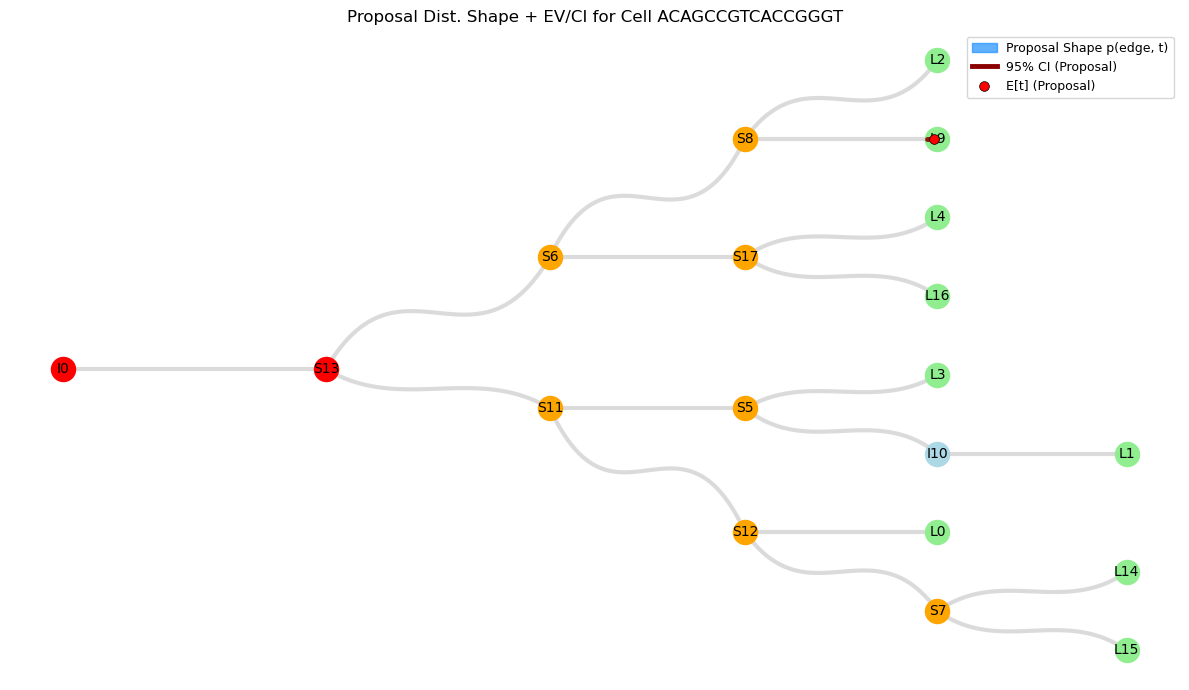


Cell AGGGAGTTCGGAAACG (Index 187):
  Proposal Target Edge: 15 (Prob: 0.098)
  Proposal E[t|edge*]: 0.887
  Proposal 95% CI [t|edge*]: [0.819, 0.941]


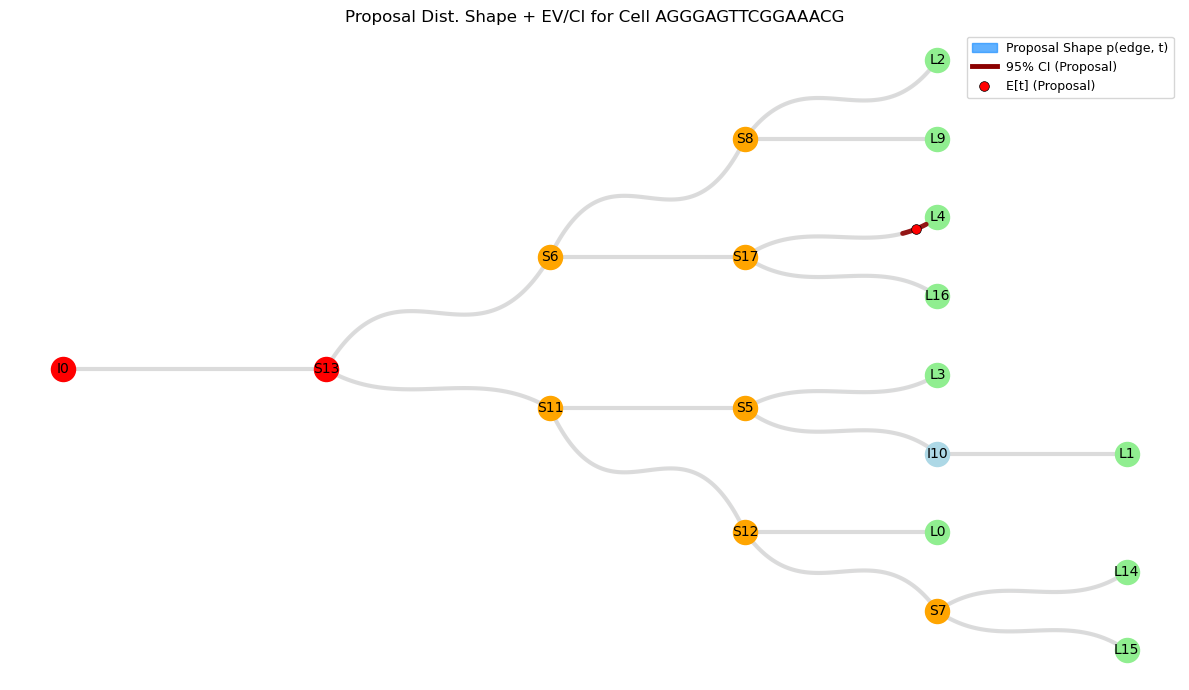


Cell GCTGGGTGTAGAGGAA (Index 3229):
  Proposal Target Edge: 8 (Prob: 0.110)
  Proposal E[t|edge*]: 0.517
  Proposal 95% CI [t|edge*]: [0.418, 0.615]


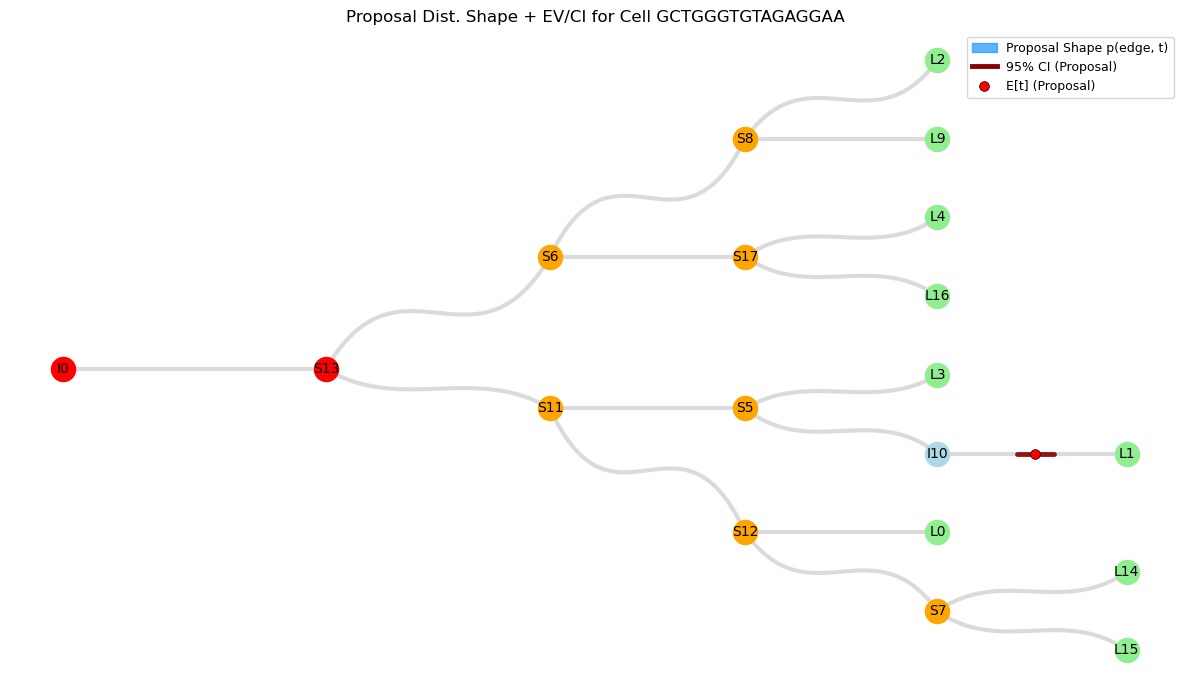


Finished plotting proposal shapes with EV/CI.


In [39]:
# %% Imports (ensure these are run)
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import networkx as nx
import random
from scipy.stats import beta as beta_dist # Alias to avoid confusion
from matplotlib.patches import Patch # For custom legend handles
from matplotlib.lines import Line2D # For custom legend handles


# Import necessary functions from your project structure
from models.proposal import compute_proposal_distribution # We need to recompute proposal params
from viz.trajectory import (
    compute_graph_layout,
    draw_graph_base,
    compute_bezier_control_points,
    # get_cell_color_map, # Not needed for this plot specifically
)
from utils.constants import EPSILON
from utils.math import cubic_bezier, cubic_bezier_derivative # Assuming these are available

# --- Ensure Required Variables Exist (from your training script) ---
# trained_posterior, belief_propagator, X, traj_graph, adata, config
# random_cell_indices (from the previous plotting chunk)
# pos (layout from previous plotting chunk)
assert 'trained_posterior' in locals(), "trained_posterior not found. Run training first."
assert 'belief_propagator' in locals(), "belief_propagator not found. Run training first."
assert 'X' in locals(), "X not found. Run training first."
assert 'traj_graph' in locals(), "traj_graph not found. Run training first."
assert 'adata' in locals(), "adata not found. Run training first."
assert 'config' in locals(), "config not found. Run training first."
assert 'random_cell_indices' in locals(), "random_cell_indices not found. Run previous plot chunk."
assert 'pos' in locals(), "pos layout not found. Run previous plot chunk."

# --- Plotting Parameters ---
PROPOSAL_RESOLUTION = 50
PROPOSAL_COLOR = 'dodgerblue' # Color for the proposal ribbons
PROPOSAL_ALPHA = 0.7
PROPOSAL_WIDTH_SCALE = 0.15 # Adjust this to control max ribbon thickness
MIN_EDGE_PROB_PLOT = 1e-3 # Don't plot ribbons for edges with lower probability

# New parameters for Expected Value and CI
EV_MARKER_COLOR = 'red'
EV_MARKER_SIZE = 70
EV_MARKER_STYLE = 'o' # Circle
CI_LINE_COLOR = 'darkred'
CI_LINE_WIDTH = 3.5
CI_LINE_STYLE = '-'
CI_ALPHA = 0.9
CI_LEVEL = 0.95 # 95% Credible Interval

# Reuse previous constants if needed
NODE_SIZE = 300
EDGE_WIDTH = 3
EDGE_COLOR = 'lightgrey'
CURVE_AMOUNT = 0.8
DEVICE = config.get('device', torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# --- Recompute Proposal Distribution Parameters (if needed, or use existing) ---
# If prop_*_all variables already exist from the previous cell and are correct,
# you can comment out this recomputation block.
# print("Recomputing proposal distribution parameters...")
# with torch.no_grad():
#     prop_edge_probs_all, prop_alpha_all, prop_beta_all = compute_proposal_distribution(
#         posterior=trained_posterior,
#         belief_propagator=belief_propagator,
#         eps=EPSILON
#     )
# print("Proposal parameters computed.")
# # Move to CPU if recomputed
# prop_edge_probs_all = prop_edge_probs_all.cpu().numpy()
# prop_alpha_all = prop_alpha_all.cpu().numpy()
# prop_beta_all = prop_beta_all.cpu().numpy()
assert 'prop_edge_probs_all' in locals(), "Proposal parameters not found. Run previous cell or uncomment recomputation."


# Get mappings needed
index_to_edge = trained_posterior.index_to_edge
index_to_node = {v: k for k, v in traj_graph.node_to_index.items()}
n_edges = trained_posterior.n_edges

# --- Generate Plots for Proposal Shape with EV and CI ---
print(f"Plotting proposal shape + EV/CI for cell indices: {random_cell_indices}")

for i, cell_idx in enumerate(random_cell_indices):
    cell_id = adata.obs_names[cell_idx] # Get cell ID from adata

    # Get the proposal parameters specific to this cell
    cell_prop_edge_probs = prop_edge_probs_all[cell_idx, :] # Shape [E]
    cell_prop_alpha = prop_alpha_all[cell_idx, :]       # Shape [E]
    cell_prop_beta = prop_beta_all[cell_idx, :]        # Shape [E]

    # --- Find edge with highest proposal probability ---
    e_prop_star_idx = np.argmax(cell_prop_edge_probs)
    max_prop_edge_prob = cell_prop_edge_probs[e_prop_star_idx]

    # Get proposal alpha/beta for this highest-probability edge
    alpha_prop_star = np.maximum(cell_prop_alpha[e_prop_star_idx], EPSILON)
    beta_prop_star = np.maximum(cell_prop_beta[e_prop_star_idx], EPSILON)

    # --- Calculate EV and CI bounds using proposal parameters ---
    try:
        # Expected value (mean of Beta)
        t_prop_expected = alpha_prop_star / (alpha_prop_star + beta_prop_star)

        # Credible Interval using PPF (inverse CDF)
        lower_quantile = (1.0 - CI_LEVEL) / 2.0
        upper_quantile = 1.0 - lower_quantile
        t_prop_lower_ci = beta_dist.ppf(lower_quantile, alpha_prop_star, beta_prop_star)
        t_prop_upper_ci = beta_dist.ppf(upper_quantile, alpha_prop_star, beta_prop_star)

        # Clamp CI bounds to be strictly within (0, 1) for safety
        t_prop_lower_ci = np.clip(t_prop_lower_ci, EPSILON, 1.0 - EPSILON)
        t_prop_upper_ci = np.clip(t_prop_upper_ci, EPSILON, 1.0 - EPSILON)

        print(f"\nCell {cell_id} (Index {cell_idx}):")
        print(f"  Proposal Target Edge: {e_prop_star_idx} (Prob: {max_prop_edge_prob:.3f})")
        print(f"  Proposal E[t|edge*]: {t_prop_expected:.3f}")
        print(f"  Proposal {CI_LEVEL*100:.0f}% CI [t|edge*]: [{t_prop_lower_ci:.3f}, {t_prop_upper_ci:.3f}]")
        ev_ci_calculated = True
    except Exception as e:
        print(f"\nCell {cell_id} (Index {cell_idx}):")
        print(f"  Proposal Target Edge: {e_prop_star_idx} (Prob: {max_prop_edge_prob:.3f})")
        print(f"  WARNING: Could not calculate EV/CI for edge {e_prop_star_idx}. Alpha={alpha_prop_star:.2e}, Beta={beta_prop_star:.2e}. Error: {e}")
        ev_ci_calculated = False


    # --- Create Plot ---
    plt.figure(figsize=(12, 7))
    ax = plt.gca()

    # Draw the base trajectory
    draw_graph_base(
        traj_graph.G_traj, pos,
        node_size=NODE_SIZE,
        edge_width=EDGE_WIDTH,
        edge_color=EDGE_COLOR,
        curve_amount=CURVE_AMOUNT
    )

    # Time values for evaluating Beta PDF along edges
    t_vals = np.linspace(0, 1, PROPOSAL_RESOLUTION)
    t_vals_pdf = np.linspace(EPSILON, 1.0 - EPSILON, PROPOSAL_RESOLUTION)

    # Plot proposal ribbons for each edge (same as before)
    for edge_idx in range(n_edges):
        edge_prob = cell_prop_edge_probs[edge_idx]
        if edge_prob < MIN_EDGE_PROB_PLOT: continue

        alpha = np.maximum(cell_prop_alpha[edge_idx], EPSILON)
        beta_p = np.maximum(cell_prop_beta[edge_idx], EPSILON)
        pdf_vals = beta_dist.pdf(t_vals_pdf, alpha, beta_p)
        pdf_vals = np.nan_to_num(pdf_vals)
        max_pdf = np.max(pdf_vals)
        if max_pdf > EPSILON: norm_pdf_vals = pdf_vals / max_pdf
        else: norm_pdf_vals = np.ones_like(pdf_vals) * 0.1

        u_idx, v_idx = index_to_edge[edge_idx]
        u_name, v_name = index_to_node.get(u_idx), index_to_node.get(v_idx)
        if u_name is None or v_name is None or u_name not in pos or v_name not in pos: continue

        P0, P1 = np.array(pos[u_name]), np.array(pos[v_name])
        if CURVE_AMOUNT > 1e-3 and abs(P0[1] - P1[1]) > 0.01 * abs(P0[0] - P1[0]):
             cp1, cp2 = compute_bezier_control_points(P0, P1, CURVE_AMOUNT)
             points = cubic_bezier(P0, cp1, cp2, P1, t_vals)
             tangents = cubic_bezier_derivative(P0, cp1, cp2, P1, t_vals)
        else:
             points = P0 + t_vals[:, None] * (P1 - P0)
             direction = P1 - P0
             if np.linalg.norm(direction) < EPSILON: continue
             tangents = np.tile(direction / np.linalg.norm(direction), (PROPOSAL_RESOLUTION, 1))

        norm_tangents = np.linalg.norm(tangents, axis=1, keepdims=True)
        valid_tangents_bool_1d = (norm_tangents > EPSILON).flatten()
        normals = np.zeros_like(tangents)
        valid_rows_indices = np.where(valid_tangents_bool_1d)[0]
        if len(valid_rows_indices) > 0:
             valid_tangent_vectors = tangents[valid_rows_indices, :]
             valid_norms = norm_tangents[valid_rows_indices, :]
             rotated_tangents = np.stack([-valid_tangent_vectors[:, 1], valid_tangent_vectors[:, 0]], axis=1)
             calculated_normals = rotated_tangents / valid_norms
             normals[valid_rows_indices, :] = calculated_normals

        widths = PROPOSAL_WIDTH_SCALE * edge_prob * norm_pdf_vals
        offset = (widths[:, None] / 2) * normals
        top_boundary = points + offset
        bottom_boundary = points - offset
        ribbon_coords = np.vstack([top_boundary, bottom_boundary[::-1]])
        ax.fill(ribbon_coords[:, 0], ribbon_coords[:, 1],
                color=PROPOSAL_COLOR, alpha=PROPOSAL_ALPHA, lw=0, zorder=5)


    # --- Plot EV and CI on the target edge ---
    if ev_ci_calculated:
        # Get coordinates for the target edge
        u_idx_star, v_idx_star = index_to_edge[e_prop_star_idx]
        u_name_star = index_to_node.get(u_idx_star)
        v_name_star = index_to_node.get(v_idx_star)

        if u_name_star and v_name_star and u_name_star in pos and v_name_star in pos:
            P0_star, P1_star = np.array(pos[u_name_star]), np.array(pos[v_name_star])

            # Check if edge is curved or straight for coordinate calculation
            is_curved_star = CURVE_AMOUNT > 1e-3 and abs(P0_star[1] - P1_star[1]) > 0.01 * abs(P0_star[0] - P1_star[0])

            if is_curved_star:
                 cp1_star, cp2_star = compute_bezier_control_points(P0_star, P1_star, CURVE_AMOUNT)
                 # Function to get point on Bezier curve
                 get_point = lambda t: cubic_bezier(P0_star, cp1_star, cp2_star, P1_star, np.array([t]))[0]
            else:
                 # Function to get point on straight line
                 direction_star = P1_star - P0_star
                 get_point = lambda t: P0_star + t * direction_star


            # Calculate EV point coordinates
            ev_coord = get_point(t_prop_expected)

            # Calculate CI segment coordinates
            ci_times = np.linspace(t_prop_lower_ci, t_prop_upper_ci, 10) # Points along CI segment
            if is_curved_star:
                ci_coords = cubic_bezier(P0_star, cp1_star, cp2_star, P1_star, ci_times)
            else:
                ci_coords = P0_star + ci_times[:, None] * direction_star


            # Plot CI segment line
            ax.plot(ci_coords[:, 0], ci_coords[:, 1], color=CI_LINE_COLOR,
                    lw=CI_LINE_WIDTH, ls=CI_LINE_STYLE, alpha=CI_ALPHA, zorder=10, solid_capstyle='round')

            # Plot EV point marker (on top of CI line)
            ax.plot(ev_coord[0], ev_coord[1], marker=EV_MARKER_STYLE, color=EV_MARKER_COLOR,
                    markersize=EV_MARKER_SIZE/10, # Adjust marker size relative scale if needed
                    markeredgecolor='black', markeredgewidth=0.5,
                    zorder=11) # Ensure EV marker is on top

        else:
             print(f"  Skipping EV/CI plotting for edge {e_prop_star_idx} due to missing node position.")


    # --- Add title and legend ---
    plt.title(f"Proposal Dist. Shape + EV/CI for Cell {cell_id}")

    # Create legend handles
    handles = []
    handles.append(Patch(color=PROPOSAL_COLOR, alpha=PROPOSAL_ALPHA,
                         label=f'Proposal Shape p(edge, t)'))
    if ev_ci_calculated:
         handles.append(Line2D([0], [0], color=CI_LINE_COLOR, lw=CI_LINE_WIDTH, ls=CI_LINE_STYLE,
                               label=f'{CI_LEVEL*100:.0f}% CI (Proposal)'))
         handles.append(Line2D([0], [0], marker=EV_MARKER_STYLE, color=EV_MARKER_COLOR,
                               markeredgecolor='black', markeredgewidth=0.5,
                               markersize=EV_MARKER_SIZE/10, linestyle='None',
                               label=f'E[t] (Proposal)'))

    ax.legend(handles=handles, loc='upper right', fontsize=9)


    plt.axis("off")
    plt.tight_layout()
    plt.show()

print("\nFinished plotting proposal shapes with EV/CI.")

Plotting Combined NLL Improvement & Sampling Difficulty for cell indices: [594, 187, 3229]

Cell ACAGCCGTCACCGGGT (Index 594): Baseline NLL = -687.91 (at posterior edge 7, t=0.980)


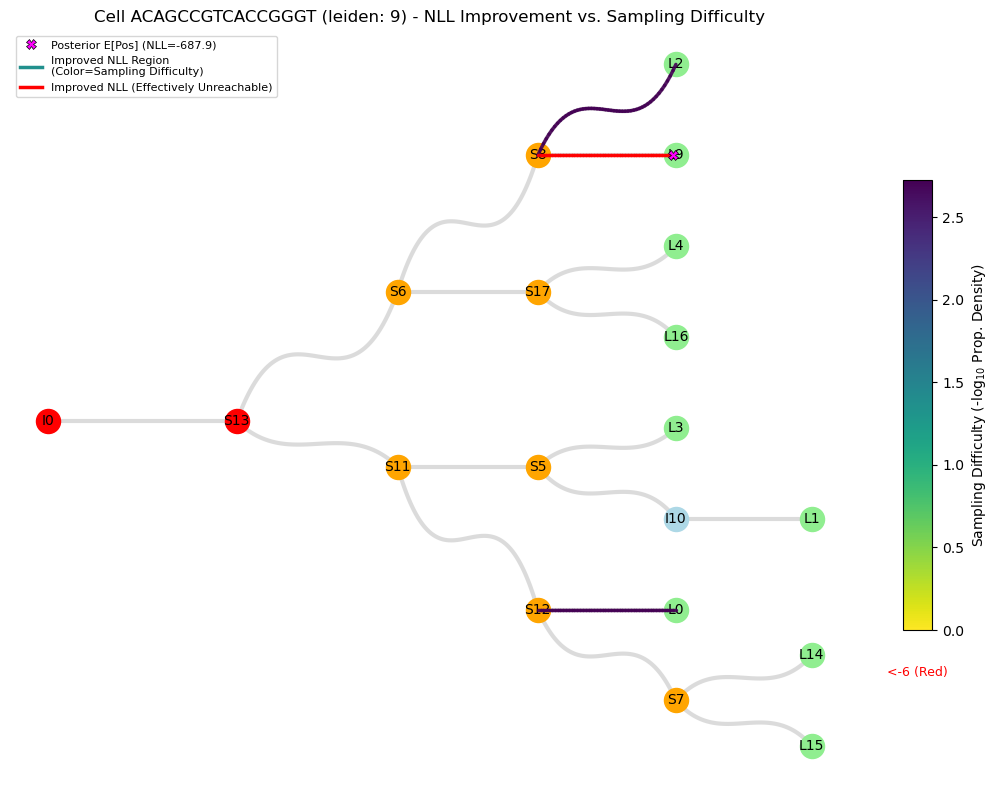


Cell AGGGAGTTCGGAAACG (Index 187): Baseline NLL = -752.54 (at posterior edge 15, t=0.887)


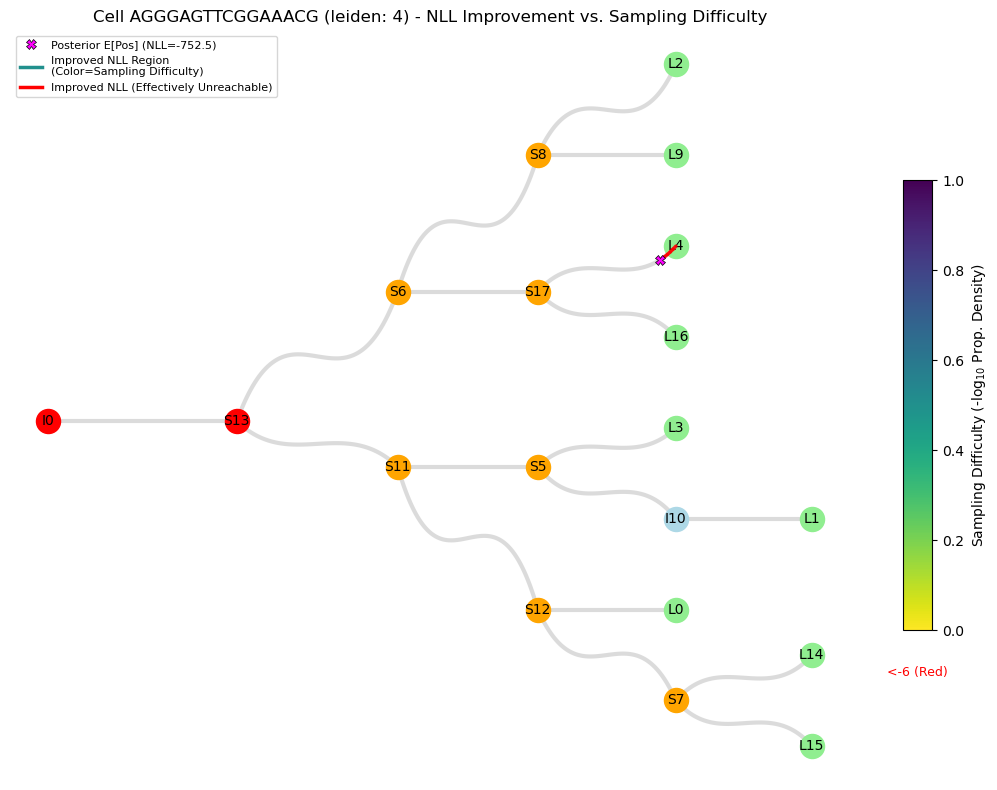


Cell GCTGGGTGTAGAGGAA (Index 3229): Baseline NLL = -646.15 (at posterior edge 8, t=0.517)


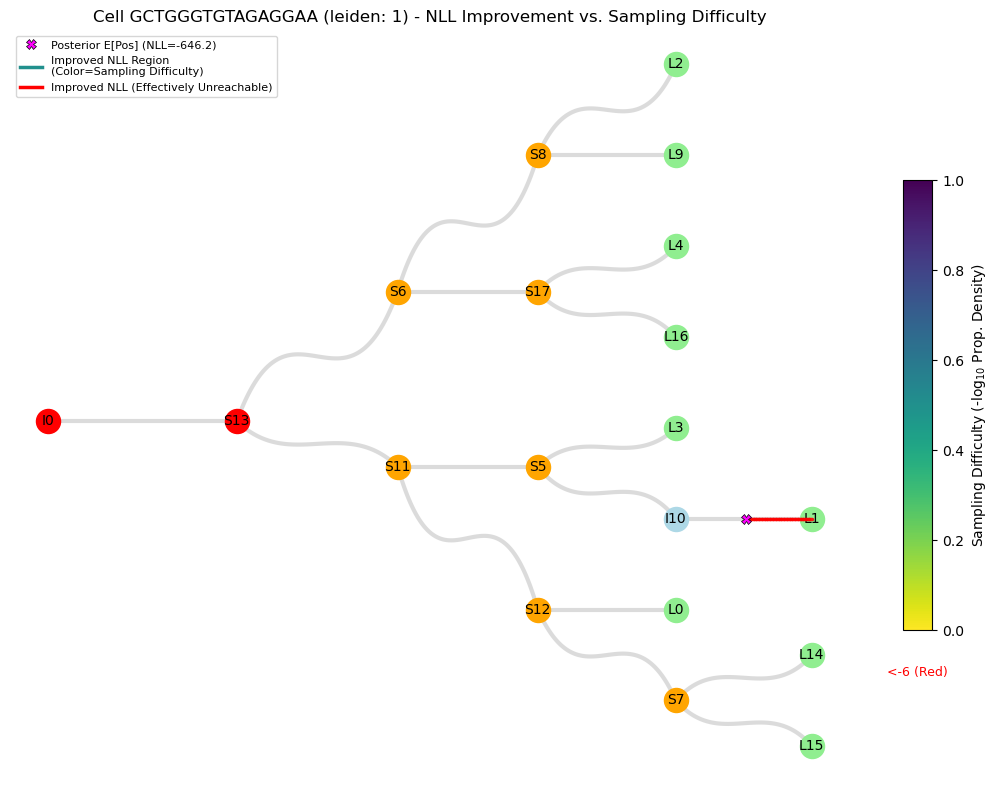


Finished plotting Combined NLL/Difficulty.


In [40]:
# %% Imports (ensure these are run)
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import networkx as nx
import random
from scipy.stats import beta as beta_dist # Alias to avoid confusion
from matplotlib.patches import Patch # For custom legend handles
from matplotlib.lines import Line2D # For custom legend handles
from matplotlib.collections import LineCollection # For colored line segments


# Import necessary functions from your project structure
from models.emission import emission_nll
from models.proposal import compute_proposal_distribution # We need proposal params
from viz.trajectory import (
    compute_graph_layout,
    draw_graph_base,
    compute_bezier_control_points,
    get_cell_color_map, # For the cell's own color
)
from utils.constants import EPSILON
from utils.math import cubic_bezier, cubic_bezier_derivative # Assuming these are available

# --- Ensure Required Variables Exist (from your training script & previous chunks) ---
# trained_posterior, belief_propagator, g, K, sigma2, pi, X, traj_graph, adata, config
# random_cell_indices, pos
# prop_edge_probs_all, prop_alpha_all, prop_beta_all (from previous cell)
assert 'trained_posterior' in locals(), "trained_posterior not found."
assert 'belief_propagator' in locals(), "belief_propagator not found."
assert 'g' in locals(), "g not found."
assert 'K' in locals(), "K not found."
assert 'sigma2' in locals(), "sigma2 not found."
assert 'X' in locals(), "X not found."
assert 'traj_graph' in locals(), "traj_graph not found."
assert 'adata' in locals(), "adata not found."
assert 'config' in locals(), "config not found."
assert 'random_cell_indices' in locals(), "random_cell_indices not found."
assert 'pos' in locals(), "pos layout not found."
assert 'prop_edge_probs_all' in locals(), "Proposal parameters not found."

# --- Plotting Parameters ---
GRID_RESOLUTION = 50 # Points per edge to evaluate NLL and proposal
COLOR_KEY = 'leiden' # For cell's own color

# Parameters for Improved NLL regions
IMPROVEMENT_CMAP = cm.viridis_r # Colormap (e.g., viridis_r: yellow=easy, purple=hard)
DANGER_COLOR = 'red'         # Color for regions essentially unreachable by proposal
DANGER_THRESHOLD_LOG_DENSITY = -6 # Log10(prop_density) threshold (-6 means prop_dens < 1e-6)
MIN_IMPROVEMENT_WIDTH = 2.5 # Min line width for colored segments
MAX_IMPROVEMENT_WIDTH = 5.0 # Max line width (can scale with improvement magnitude if desired)
IMPROVEMENT_ALPHA = 0.9

# Parameters for Cell's posterior position marker
POSTERIOR_MARKER_COLOR = 'magenta'
POSTERIOR_MARKER_SIZE = 70
POSTERIOR_MARKER_STYLE = 'O'

# Reuse other constants
NODE_SIZE = 300
EDGE_WIDTH = 3
EDGE_COLOR = 'lightgrey'
CURVE_AMOUNT = 0.8
DEVICE = config.get('device', torch.device("cuda"if torch.cuda.is_available() else"cpu"))

# --- Helper Function (Modified from NLL plot) ---
@torch.no_grad()
def calculate_nll_and_proposal_density(
    cell_x_vector, # Single cell expression [G]
    edge_idx_eval, # Scalar edge index to evaluate
    time_val_eval, # Scalar time value (0-1) to evaluate
    g_param, K_param, sigma2_param, pi_param, # Learned generative parameters
    posterior_model, traj_graph_model, # For mappings
    cell_prop_edge_p, cell_prop_a, cell_prop_b, # Proposal params for this cell [E]
    device='cpu', eps=EPSILON
):
    """Calculates NLL and proposal log density for a cell at a specific edge/time."""
    # 1. Calculate NLL
    X_batch = cell_x_vector.unsqueeze(0).to(device) # [1, G]
    P_idx_batch = torch.tensor([edge_idx_eval], dtype=torch.long, device=device) # [1]
    T_batch = torch.tensor([time_val_eval], dtype=torch.float32, device=device) # [1]

    index_to_edge_map = posterior_model.index_to_edge
    node_to_index_map = traj_graph_model.node_to_index

    g_param = g_param.to(device); K_param = K_param.to(device)
    sigma2_param = sigma2_param.to(device)
    if pi_param is not None: pi_param = pi_param.to(device)

    nll = emission_nll(
        X=X_batch, P_idx=P_idx_batch, T=T_batch, g=g_param, K=K_param,
        sigma2_param=sigma2_param, index_to_edge=index_to_edge_map,
        node_to_index=node_to_index_map, pi=pi_param, eps=eps, log_eps=eps*1e-2 # Use smaller log_eps
    ).item()

    # 2. Calculate Proposal Log Density
    prop_edge_prob = cell_prop_edge_p[edge_idx_eval]
    if prop_edge_prob < eps: # If edge prob is effectively zero, density is effectively zero
        log_prop_density = -np.inf
    else:
        alpha_prop = np.maximum(cell_prop_a[edge_idx_eval], eps)
        beta_prop = np.maximum(cell_prop_b[edge_idx_eval], eps)
        # Use logpdf for stability
        log_pdf_time = beta_dist.logpdf(np.clip(time_val_eval, eps, 1-eps), alpha_prop, beta_prop)
        # Clamp logpdf in case of numerical issues
        log_pdf_time = np.nan_to_num(log_pdf_time, nan=-np.inf, posinf=-np.inf, neginf=-np.inf)

        log_prop_density = np.log(prop_edge_prob) + log_pdf_time
        log_prop_density = np.nan_to_num(log_prop_density, nan=-np.inf, posinf=-np.inf, neginf=-np.inf)


    return nll, log_prop_density # Return NLL and log10 proposal density

# --- Setup ---
trained_posterior.eval()
X = X.to(DEVICE)
g = g.to(DEVICE); K = K.to(DEVICE); sigma2 = sigma2.to(DEVICE)
if pi is not None: pi = pi.to(DEVICE)

# Use proposal params already computed and moved to CPU
# prop_edge_probs_all, prop_alpha_all, prop_beta_all are numpy arrays

index_to_edge = trained_posterior.index_to_edge
index_to_node = {v: k for k, v in traj_graph.node_to_index.items()}
n_edges = trained_posterior.n_edges
cell_colors_raw, get_color_func, _, _, _ = get_cell_color_map(adata, COLOR_KEY)


# --- Generate Plots ---
print(f"Plotting Combined NLL Improvement & Sampling Difficulty for cell indices: {random_cell_indices}")

for i, cell_idx in enumerate(random_cell_indices):
    cell_id = adata.obs_names[cell_idx]
    X_cell = X[cell_idx]

    # Get proposal params for this cell
    cell_prop_edge_p = prop_edge_probs_all[cell_idx, :]
    cell_prop_a = prop_alpha_all[cell_idx, :]
    cell_prop_b = prop_beta_all[cell_idx, :]

    # --- 1. Calculate Baseline NLL (using posterior assignment) ---
    with torch.no_grad():
        edge_logits_cell = trained_posterior.edge_logits[cell_idx]
        q_edge_probs_cell = torch.softmax(edge_logits_cell, dim=0)
        e_posterior_star_idx = q_edge_probs_cell.argmax().item()
        alpha_post_star = trained_posterior.alpha.data[cell_idx, e_posterior_star_idx].clamp(min=EPSILON)
        beta_post_star = trained_posterior.beta.data[cell_idx, e_posterior_star_idx].clamp(min=EPSILON)
        t_posterior_expected = (alpha_post_star / (alpha_post_star + beta_post_star)).item()

    baseline_nll, _ = calculate_nll_and_proposal_density(
        X_cell, e_posterior_star_idx, t_posterior_expected,
        g, K, sigma2, pi, trained_posterior, traj_graph,
        cell_prop_edge_p, cell_prop_a, cell_prop_b, # Pass proposal params
        device=DEVICE
    )
    print(f"\nCell {cell_id} (Index {cell_idx}): Baseline NLL = {baseline_nll:.2f} (at posterior edge {e_posterior_star_idx}, t={t_posterior_expected:.3f})")

    # --- 2. Evaluate NLL and Proposal Density across Grid ---
    time_grid = np.linspace(EPSILON, 1.0 - EPSILON, GRID_RESOLUTION)
    all_segments_data = [] # Store data for LineCollection
    min_log_density = 0 # Track min/max for normalization (positive values)
    max_log_density = -np.inf

    for edge_idx_eval in range(n_edges):
        nll_values = np.zeros(GRID_RESOLUTION)
        log_prop_density_values = np.zeros(GRID_RESOLUTION)

        for t_idx, t_eval in enumerate(time_grid):
            nll, log_prop_density = calculate_nll_and_proposal_density(
                X_cell, edge_idx_eval, t_eval,
                g, K, sigma2, pi, trained_posterior, traj_graph,
                cell_prop_edge_p, cell_prop_a, cell_prop_b,
                device=DEVICE
            )
            nll_values[t_idx] = nll
            # We store -log(density) as the difficulty metric
            log_prop_density_values[t_idx] = -log_prop_density if np.isfinite(log_prop_density) else np.inf


        # Find segments where NLL < baseline_nll
        improved_mask = nll_values < baseline_nll
        if not np.any(improved_mask): continue

        # Get edge coordinates
        u_idx, v_idx = index_to_edge[edge_idx_eval]
        u_name, v_name = index_to_node.get(u_idx), index_to_node.get(v_idx)
        if u_name is None or v_name is None or u_name not in pos or v_name not in pos: continue
        P0, P1 = np.array(pos[u_name]), np.array(pos[v_name])
        is_curved = CURVE_AMOUNT > 1e-3 and abs(P0[1] - P1[1]) > 0.01 * abs(P0[0] - P1[0])
        if is_curved: cp1, cp2 = compute_bezier_control_points(P0, P1, CURVE_AMOUNT)
        else: direction = P1 - P0

        # Process contiguous segments of improvement
        start_idx = None
        for idx in range(GRID_RESOLUTION):
            if improved_mask[idx] and start_idx is None:
                start_idx = idx
            elif (not improved_mask[idx] or idx == GRID_RESOLUTION - 1) and start_idx is not None:
                end_idx = idx if improved_mask[idx] else idx - 1
                if start_idx <= end_idx:
                    # Extract segment data
                    seg_times = time_grid[start_idx : end_idx + 1]
                    seg_log_densities = log_prop_density_values[start_idx : end_idx + 1]

                    # Calculate segment coordinates
                    if is_curved:
                        seg_coords = cubic_bezier(P0, cp1, cp2, P1, seg_times)
                    else:
                        if np.linalg.norm(direction) < EPSILON: continue # Skip zero-length edges
                        seg_coords = P0 + seg_times[:, None] * direction

                    # Store segment points and average difficulty (-log(density))
                    # We need pairs of points for LineCollection
                    points = seg_coords.reshape(-1, 1, 2)
                    segments = np.concatenate([points[:-1], points[1:]], axis=1) # Shape (N_pairs, 2, 2)
                    # Use average difficulty for the whole small segment line
                    avg_difficulty = np.mean(seg_log_densities[np.isfinite(seg_log_densities)]) if np.any(np.isfinite(seg_log_densities)) else np.inf

                    all_segments_data.append({
                        "segments": segments,
                        "difficulty": avg_difficulty # Store -log(density)
                    })

                    # Update min/max difficulty observed (excluding danger zone for normalization)
                    # Convert difficulty back to log_density for threshold check
                    log_density_check = -avg_difficulty
                    if log_density_check > DANGER_THRESHOLD_LOG_DENSITY and np.isfinite(avg_difficulty):
                         min_log_density = min(min_log_density, avg_difficulty)
                         max_log_density = max(max_log_density, avg_difficulty)

                start_idx = None # Reset for next segment

    # Handle potential case where max_log_density wasn't updated (only danger zones found)
    if not np.isfinite(max_log_density):
        max_log_density = min_log_density + 1.0 # Add a small range if only one value or inf

    # Avoid division by zero if min/max are the same
    if max_log_density <= min_log_density:
         max_log_density = min_log_density + 1.0


    # --- 3. Create Plot ---
    plt.figure(figsize=(12, 8)) # Slightly taller for colorbar
    ax = plt.gca()
    draw_graph_base(traj_graph.G_traj, pos, node_size=NODE_SIZE, edge_width=EDGE_WIDTH, edge_color=EDGE_COLOR, curve_amount=CURVE_AMOUNT)

    # --- 4. Plot Improved NLL Segments with Coloring ---
    if all_segments_data:
        # Prepare data for LineCollection
        all_lines = []
        all_colors = []
        norm = mcolors.Normalize(vmin=min_log_density, vmax=max_log_density)

        for data in all_segments_data:
            difficulty = data['difficulty']
            log_density = -difficulty # Convert back for threshold check

            if log_density <= DANGER_THRESHOLD_LOG_DENSITY or not np.isfinite(difficulty):
                color = DANGER_COLOR
            else:
                # Normalize difficulty score (0=easy, 1=hard within non-danger range)
                norm_difficulty = norm(difficulty)
                color = IMPROVEMENT_CMAP(norm_difficulty)

            all_lines.extend(data['segments'])
            # Assign the determined color to all pairs within this segment
            all_colors.extend([color] * len(data['segments']))


        if all_lines:
            # Create LineCollection
            # Use a fixed line width for simplicity now
            lc = LineCollection(all_lines, colors=all_colors, linewidths=MIN_IMPROVEMENT_WIDTH,
                                alpha=IMPROVEMENT_ALPHA, zorder=6, capstyle='round')
            ax.add_collection(lc)

            # Add Colorbar
            sm = cm.ScalarMappable(cmap=IMPROVEMENT_CMAP, norm=norm)
            sm.set_array([]) # Important!
            cbar = plt.colorbar(sm, ax=ax, shrink=0.6, aspect=15)
            cbar.set_label(f'Sampling Difficulty (-log$_{{10}}$ Prop. Density)')
            # Add annotation for danger color if used
            if any(c == DANGER_COLOR for c in all_colors):
                 cbar.ax.text(0.5, -0.08, f'<{DANGER_THRESHOLD_LOG_DENSITY:.0f} (Red)', transform=cbar.ax.transAxes,
                              ha='center', va='top', color=DANGER_COLOR, fontsize=9)


    # --- 5. Plot Cell's Posterior Position ---
    u_idx_post, v_idx_post = index_to_edge[e_posterior_star_idx]
    u_name_post, v_name_post = index_to_node.get(u_idx_post), index_to_node.get(v_idx_post)
    if u_name_post and v_name_post and u_name_post in pos and v_name_post in pos:
        P0_post, P1_post = np.array(pos[u_name_post]), np.array(pos[v_name_post])
        is_curved_post = CURVE_AMOUNT > 1e-3 and abs(P0_post[1] - P1_post[1]) > 0.01 * abs(P0_post[0] - P1_post[0])
        if is_curved_post: cp1_post, cp2_post = compute_bezier_control_points(P0_post, P1_post, CURVE_AMOUNT)

        if is_curved_post: post_coord = cubic_bezier(P0_post, cp1_post, cp2_post, P1_post, np.array([t_posterior_expected]))[0]
        else: post_coord = P0_post + t_posterior_expected * (P1_post - P0_post)

        ax.plot(post_coord[0], post_coord[1], marker=POSTERIOR_MARKER_STYLE, color=POSTERIOR_MARKER_COLOR,
                markersize=POSTERIOR_MARKER_SIZE/10,
                markeredgecolor='black', markeredgewidth=0.5,
                zorder=11, linestyle='None') # Marker only

    # --- 6. Title and Legend ---
    cell_color_val = cell_colors_raw.loc[cell_id]
    cell_color_val = cell_color_val.iloc[0] if isinstance(cell_color_val, pd.Series) else cell_color_val
    plot_color = get_color_func(cell_color_val)

    plt.title(f"Cell {cell_id} ({COLOR_KEY}: {cell_color_val}) - NLL Improvement vs. Sampling Difficulty")

    # Custom Legend
    legend_handles = []
    legend_handles.append(Line2D([0], [0], marker=POSTERIOR_MARKER_STYLE, color=POSTERIOR_MARKER_COLOR,
                                  markeredgecolor='black', markeredgewidth=0.5,
                                  markersize=POSTERIOR_MARKER_SIZE/10, linestyle='None',
                                  label=f'Posterior E[Pos] (NLL={baseline_nll:.1f})'))
    # Represent the colored lines (use a sample color)
    legend_handles.append(Line2D([0],[0], color=IMPROVEMENT_CMAP(0.5), lw=MIN_IMPROVEMENT_WIDTH,
                                 label=f'Improved NLL Region\n(Color=Sampling Difficulty)'))
    # Add danger color explanation if relevant
    if any(data['difficulty'] == np.inf or -data['difficulty'] <= DANGER_THRESHOLD_LOG_DENSITY for data in all_segments_data):
         legend_handles.append(Line2D([0],[0], color=DANGER_COLOR, lw=MIN_IMPROVEMENT_WIDTH,
                                      label=f'Improved NLL (Effectively Unreachable)'))


    ax.legend(handles=legend_handles, loc='upper left', fontsize=8, bbox_to_anchor=(0, 1))

    plt.axis("off")
    plt.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust layout to make space for colorbar
    plt.show()

print("\nFinished plotting Combined NLL/Difficulty.")

In [49]:
# %% Imports for Widget
import ipywidgets as widgets
from IPython.display import display, clear_output
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import networkx as nx
import random
from scipy.stats import beta as beta_dist
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.collections import LineCollection
import math # For log10

# Import necessary functions from your project structure
# *** Ensure the MODIFIED version is imported or available ***
from models.proposal import compute_proposal_distribution # Should now accept diffusion params
from models.emission import emission_nll
from viz.trajectory import (
    compute_graph_layout,
    draw_graph_base,
    compute_bezier_control_points,
    get_cell_color_map,
)
from utils.constants import EPSILON
from utils.math import cubic_bezier, cubic_bezier_derivative

# --- Ensure Required Variables Exist (from training script & previous chunks) ---
# trained_posterior, belief_propagator, g, K, sigma2, pi, X, traj_graph, adata, config
# random_cell_indices, pos
assert 'trained_posterior' in locals(), "trained_posterior not found."
assert 'belief_propagator' in locals(), "belief_propagator not found."
assert 'g' in locals(), "g not found."
assert 'K' in locals(), "K not found."
assert 'sigma2' in locals(), "sigma2 not found."
assert 'X' in locals(), "X not found."
assert 'traj_graph' in locals(), "traj_graph not found."
assert 'adata' in locals(), "adata not found."
assert 'config' in locals(), "config not found."
assert 'random_cell_indices' in locals(), "random_cell_indices not found."
assert 'pos' in locals(), "pos layout not found."

# --- Widget Parameters & Constants ---
GRID_RESOLUTION = 30 # Lower resolution for faster interaction
COLOR_KEY = 'leiden' # For cell's own color
IMPROVEMENT_CMAP = cm.plasma_r # Colormap (plasma_r: yellow=easy -> dark blue=hard)
DANGER_COLOR = 'grey'         # Color for unreachable regions
# Log10(Prob) threshold. Below this, expect > 10^X samples. E.g., -8 means > 100M samples
DANGER_THRESHOLD_LOG_DENSITY = -8
MIN_IMPROVEMENT_WIDTH = 2.5
MAX_IMPROVEMENT_WIDTH = 5.0
IMPROVEMENT_ALPHA = 0.9
POSTERIOR_MARKER_COLOR = 'magenta'
POSTERIOR_MARKER_SIZE = 70
POSTERIOR_MARKER_STYLE = 'X'
PROPOSAL_EV_MARKER_COLOR = 'red'
PROPOSAL_EV_MARKER_SIZE = 70
PROPOSAL_EV_MARKER_STYLE = 'o'
PROPOSAL_CI_LINE_COLOR = 'darkred'
PROPOSAL_CI_LINE_WIDTH = 3.5
PROPOSAL_CI_ALPHA = 0.9
PROPOSAL_CI_LEVEL = 0.95
PROPOSAL_RIBBON_COLOR = 'dodgerblue'
PROPOSAL_RIBBON_ALPHA = 0.6 # Slightly more transparent
PROPOSAL_WIDTH_SCALE = 0.15
MIN_EDGE_PROB_PLOT = 1e-4 # Lower threshold a bit

NODE_SIZE = 300
EDGE_WIDTH = 3
EDGE_COLOR = 'lightgrey'
CURVE_AMOUNT = 0.8
DEVICE = config.get('device', torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# --- Static Setup ---
trained_posterior.eval()
X = X.to(DEVICE)
g = g.to(DEVICE); K = K.to(DEVICE); sigma2 = sigma2.to(DEVICE)
if pi is not None: pi = pi.to(DEVICE)

index_to_edge = trained_posterior.index_to_edge
index_to_node = {v: k for k, v in traj_graph.node_to_index.items()}
n_edges = trained_posterior.n_edges
cell_colors_raw, get_color_func, _, _, _ = get_cell_color_map(adata, COLOR_KEY)
cell_ids = adata.obs_names[random_cell_indices].tolist()

# --- Helper Function (NLL and Log Proposal Density) ---
# (Same as before)
@torch.no_grad()
def calculate_nll_and_proposal_density(
    cell_x_vector, edge_idx_eval, time_val_eval,
    g_param, K_param, sigma2_param, pi_param,
    posterior_model, traj_graph_model,
    cell_prop_edge_p, cell_prop_a, cell_prop_b,
    device='cpu', eps=EPSILON):
    # 1. NLL calculation...
    X_batch = cell_x_vector.unsqueeze(0).to(device)
    P_idx_batch = torch.tensor([edge_idx_eval], dtype=torch.long, device=device)
    T_batch = torch.tensor([time_val_eval], dtype=torch.float32, device=device)
    index_to_edge_map = posterior_model.index_to_edge
    node_to_index_map = traj_graph_model.node_to_index
    g_param = g_param.to(device); K_param = K_param.to(device)
    sigma2_param = sigma2_param.to(device)
    if pi_param is not None: pi_param = pi_param.to(device)
    nll = emission_nll(
        X=X_batch, P_idx=P_idx_batch, T=T_batch, g=g_param, K=K_param,
        sigma2_param=sigma2_param, index_to_edge=index_to_edge_map,
        node_to_index=node_to_index_map, pi=pi_param, eps=eps, log_eps=eps*1e-2
    ).item()

    # 2. Proposal Log Density calculation...
    prop_edge_prob = cell_prop_edge_p[edge_idx_eval]
    if prop_edge_prob < eps:
        log_prop_density = -np.inf
    else:
        alpha_prop = np.maximum(cell_prop_a[edge_idx_eval], eps)
        beta_prop = np.maximum(cell_prop_b[edge_idx_eval], eps)
        log_pdf_time = beta_dist.logpdf(np.clip(time_val_eval, eps, 1-eps), alpha_prop, beta_prop)
        log_pdf_time = np.nan_to_num(log_pdf_time, nan=-np.inf, posinf=-np.inf, neginf=-np.inf)
        log_prop_density = np.log(prop_edge_prob) + log_pdf_time # Use natural log internally
        log_prop_density = np.nan_to_num(log_prop_density, nan=-np.inf, posinf=-np.inf, neginf=-np.inf)

    return nll, log_prop_density


# --- Main Plotting Function for the Widget ---
# This function will be called whenever a slider changes.
def update_interactive_plots(cell_index_in_list, prop_beta_const, prop_target_temp, diffusion_alpha, diffusion_steps):

    cell_idx = random_cell_indices[cell_index_in_list] # Get actual AnnData index
    cell_id = cell_ids[cell_index_in_list]
    X_cell = X[cell_idx]

    # --- 1. Recalculate Proposal Distribution ---
    # This is the core part that responds to sliders
    with torch.no_grad():
        prop_edge_probs_all_t, prop_alpha_all_t, prop_beta_all_t = compute_proposal_distribution(
            posterior=trained_posterior,
            belief_propagator=belief_propagator,
            proposal_beta_const=prop_beta_const,
            proposal_target_temp=prop_target_temp,
            diffusion_alpha=diffusion_alpha,
            diffusion_steps=int(diffusion_steps), # Ensure steps is int
            eps=EPSILON
        )
        # Move results for the specific cell to CPU/Numpy
        cell_prop_edge_p = prop_edge_probs_all_t[cell_idx].cpu().numpy()
        cell_prop_a = prop_alpha_all_t[cell_idx].cpu().numpy()
        cell_prop_b = prop_beta_all_t[cell_idx].cpu().numpy()

    # --- 2. Calculate Baseline NLL (Posterior based) ---
    with torch.no_grad():
        edge_logits_cell = trained_posterior.edge_logits[cell_idx]
        q_edge_probs_cell = torch.softmax(edge_logits_cell, dim=0)
        e_posterior_star_idx = q_edge_probs_cell.argmax().item()
        alpha_post_star = trained_posterior.alpha.data[cell_idx, e_posterior_star_idx].clamp(min=EPSILON)
        beta_post_star = trained_posterior.beta.data[cell_idx, e_posterior_star_idx].clamp(min=EPSILON)
        t_posterior_expected = (alpha_post_star / (alpha_post_star + beta_post_star)).item()

    baseline_nll, _ = calculate_nll_and_proposal_density(
        X_cell, e_posterior_star_idx, t_posterior_expected,
        g, K, sigma2, pi, trained_posterior, traj_graph,
        cell_prop_edge_p, cell_prop_a, cell_prop_b, device=DEVICE) # Pass current proposal params

    # --- 3. Evaluate Grid & Find Improvements ---
    time_grid = np.linspace(EPSILON, 1.0 - EPSILON, GRID_RESOLUTION)
    all_segments_data = []
    min_log_density = 0
    max_log_density = -np.inf # Using natural log internally now

    for edge_idx_eval in range(n_edges):
        nll_values = np.zeros(GRID_RESOLUTION)
        log_prop_density_values = np.zeros(GRID_RESOLUTION) # Natural log
        for t_idx, t_eval in enumerate(time_grid):
            nll, log_prop_density = calculate_nll_and_proposal_density(
                X_cell, edge_idx_eval, t_eval,
                g, K, sigma2, pi, trained_posterior, traj_graph,
                cell_prop_edge_p, cell_prop_a, cell_prop_b, device=DEVICE)
            nll_values[t_idx] = nll
            log_prop_density_values[t_idx] = log_prop_density # Store natural log

        improved_mask = nll_values < baseline_nll
        if not np.any(improved_mask): continue

        u_idx, v_idx = index_to_edge[edge_idx_eval]
        u_name, v_name = index_to_node.get(u_idx), index_to_node.get(v_idx)
        if u_name is None or v_name is None or u_name not in pos or v_name not in pos: continue
        P0, P1 = np.array(pos[u_name]), np.array(pos[v_name])
        is_curved = CURVE_AMOUNT > 1e-3 and abs(P0[1] - P1[1]) > 0.01 * abs(P0[0] - P1[0])
        if is_curved: cp1, cp2 = compute_bezier_control_points(P0, P1, CURVE_AMOUNT)
        else: direction = P1 - P0; norm_dir = np.linalg.norm(direction); continue_edge = norm_dir > EPSILON

        start_idx = None
        for idx in range(GRID_RESOLUTION):
            if improved_mask[idx] and start_idx is None: start_idx = idx
            elif (not improved_mask[idx] or idx == GRID_RESOLUTION - 1) and start_idx is not None:
                end_idx = idx if improved_mask[idx] else idx - 1
                if start_idx <= end_idx:
                    seg_times = time_grid[start_idx : end_idx + 1]
                    seg_log_densities = log_prop_density_values[start_idx : end_idx + 1]

                    if is_curved: seg_coords = cubic_bezier(P0, cp1, cp2, P1, seg_times)
                    elif continue_edge: seg_coords = P0 + seg_times[:, None] * direction
                    else: break # Skip if straight edge has zero length

                    points = seg_coords.reshape(-1, 1, 2)
                    segments = np.concatenate([points[:-1], points[1:]], axis=1)
                    # Difficulty metric: -log_e(density)
                    avg_difficulty = -np.mean(seg_log_densities[np.isfinite(seg_log_densities)]) if np.any(np.isfinite(seg_log_densities)) else np.inf

                    all_segments_data.append({"segments": segments, "difficulty": avg_difficulty})

                    # Use log10 for threshold check and range finding
                    log10_density = np.log10(np.exp(np.mean(seg_log_densities[np.isfinite(seg_log_densities)]))) if np.any(np.isfinite(seg_log_densities)) else -np.inf

                    if log10_density > DANGER_THRESHOLD_LOG_DENSITY and np.isfinite(avg_difficulty):
                         # Track min/max of the difficulty metric (-log_e)
                         min_log_density = min(min_log_density, avg_difficulty)
                         max_log_density = max(max_log_density, avg_difficulty)
                start_idx = None

    if not np.isfinite(max_log_density): max_log_density = min_log_density + 1.0
    if max_log_density <= min_log_density: max_log_density = min_log_density + 1.0

    # --- 4. Create Figure and Axes ---
    # Clear previous output if any (important for interactive updates)
    # clear_output(wait=True) # Might cause flickering, interactive_output handles this
    fig, axes = plt.subplots(1, 2, figsize=(18, 7)) # Two plots side-by-side

    # --- 5. Plot 1: Proposal Shape + EV/CI ---
    ax = axes[0]
    plt.sca(ax)
    draw_graph_base(traj_graph.G_traj, pos, node_size=NODE_SIZE, edge_width=EDGE_WIDTH, edge_color=EDGE_COLOR, curve_amount=CURVE_AMOUNT)


    # Plot proposal ribbons
    for edge_idx in range(n_edges):
        edge_prob = cell_prop_edge_p[edge_idx]
        if edge_prob < MIN_EDGE_PROB_PLOT: continue
        alpha = np.maximum(cell_prop_a[edge_idx], EPSILON)
        beta_p = np.maximum(cell_prop_b[edge_idx], EPSILON)
        pdf_vals = beta_dist.pdf(np.linspace(EPSILON, 1-EPSILON, GRID_RESOLUTION), alpha, beta_p)
        pdf_vals = np.nan_to_num(pdf_vals); max_pdf = np.max(pdf_vals)
        norm_pdf_vals = pdf_vals / max_pdf if max_pdf > EPSILON else np.ones_like(pdf_vals)*0.1

        u_idx, v_idx = index_to_edge[edge_idx]
        u_name, v_name = index_to_node.get(u_idx), index_to_node.get(v_idx)
        if u_name is None or v_name is None or u_name not in pos or v_name not in pos: continue
        P0, P1 = np.array(pos[u_name]), np.array(pos[v_name])
        # (Logic for calculating points, tangents, normals, widths, offset, ribbon_coords - same as before)
        # ... [omitted for brevity - copy from previous working proposal plot] ...
        is_curved = CURVE_AMOUNT > 1e-3 and abs(P0[1] - P1[1]) > 0.01 * abs(P0[0] - P1[0])
        if is_curved:
             cp1, cp2 = compute_bezier_control_points(P0, P1, CURVE_AMOUNT)
             points = cubic_bezier(P0, cp1, cp2, P1, time_grid)
             tangents = cubic_bezier_derivative(P0, cp1, cp2, P1, time_grid)
        else:
             direction = P1-P0; norm_dir = np.linalg.norm(direction);
             if norm_dir < EPSILON: continue
             points = P0 + time_grid[:, None] * direction
             tangents = np.tile(direction / norm_dir, (GRID_RESOLUTION, 1))

        norm_tangents = np.linalg.norm(tangents, axis=1, keepdims=True)
        valid_tangents_bool_1d = (norm_tangents > EPSILON).flatten()
        normals = np.zeros_like(tangents)
        valid_rows_indices = np.where(valid_tangents_bool_1d)[0]
        if len(valid_rows_indices) > 0:
             valid_tangent_vectors = tangents[valid_rows_indices, :]
             valid_norms = norm_tangents[valid_rows_indices, :]
             rotated_tangents = np.stack([-valid_tangent_vectors[:, 1], valid_tangent_vectors[:, 0]], axis=1)
             calculated_normals = rotated_tangents / valid_norms
             normals[valid_rows_indices, :] = calculated_normals

        widths = PROPOSAL_WIDTH_SCALE * edge_prob * norm_pdf_vals
        offset = (widths[:, None] / 2) * normals
        top_boundary = points + offset
        bottom_boundary = points - offset
        ribbon_coords = np.vstack([top_boundary, bottom_boundary[::-1]])
        ax.fill(ribbon_coords[:, 0], ribbon_coords[:, 1], color=PROPOSAL_RIBBON_COLOR, alpha=PROPOSAL_RIBBON_ALPHA, lw=0, zorder=5)


    # Plot Proposal EV and CI for the *current* proposal's target edge
    e_prop_star_idx = np.argmax(cell_prop_edge_p)
    alpha_prop_star = np.maximum(cell_prop_a[e_prop_star_idx], EPSILON)
    beta_prop_star = np.maximum(cell_prop_b[e_prop_star_idx], EPSILON)
    try:
        t_prop_expected = alpha_prop_star / (alpha_prop_star + beta_prop_star)
        t_prop_lower_ci = beta_dist.ppf((1.0 - PROPOSAL_CI_LEVEL) / 2.0, alpha_prop_star, beta_prop_star)
        t_prop_upper_ci = beta_dist.ppf(1.0 - (1.0 - PROPOSAL_CI_LEVEL) / 2.0, alpha_prop_star, beta_prop_star)
        t_prop_lower_ci = np.clip(t_prop_lower_ci, EPSILON, 1.0 - EPSILON)
        t_prop_upper_ci = np.clip(t_prop_upper_ci, EPSILON, 1.0 - EPSILON)
        ev_ci_calculated = True
    except Exception: ev_ci_calculated = False

    if ev_ci_calculated:
        u_idx_star, v_idx_star = index_to_edge[e_prop_star_idx]
        u_name_star, v_name_star = index_to_node.get(u_idx_star), index_to_node.get(v_idx_star)
        if u_name_star and v_name_star and u_name_star in pos and v_name_star in pos:
            P0_star, P1_star = np.array(pos[u_name_star]), np.array(pos[v_name_star])
            is_curved_star = CURVE_AMOUNT > 1e-3 and abs(P0_star[1] - P1_star[1]) > 0.01 * abs(P0_star[0] - P1_star[0])
            if is_curved_star: cp1_star, cp2_star = compute_bezier_control_points(P0_star, P1_star, CURVE_AMOUNT)

            get_point = lambda t: cubic_bezier(P0_star, cp1_star, cp2_star, P1_star, np.array([t]))[0] if is_curved_star else P0_star + t * (P1_star - P0_star)
            ev_coord = get_point(t_prop_expected)
            ci_times = np.linspace(t_prop_lower_ci, t_prop_upper_ci, 10)
            ci_coords = cubic_bezier(P0_star, cp1_star, cp2_star, P1_star, ci_times) if is_curved_star else P0_star + ci_times[:, None] * (P1_star - P0_star)

            ax.plot(ci_coords[:, 0], ci_coords[:, 1], color=PROPOSAL_CI_LINE_COLOR, lw=PROPOSAL_CI_LINE_WIDTH, ls='-', alpha=PROPOSAL_CI_ALPHA, zorder=10, solid_capstyle='round')
            ax.plot(ev_coord[0], ev_coord[1], marker=PROPOSAL_EV_MARKER_STYLE, color=PROPOSAL_EV_MARKER_COLOR, markersize=PROPOSAL_EV_MARKER_SIZE/10, markeredgecolor='black', markeredgewidth=0.5, zorder=11)

    ax.set_title(f"Proposal Shape + EV/CI (Cell {cell_id})")
    ax.axis("off")
    handles_p = [Patch(color=PROPOSAL_RIBBON_COLOR, alpha=PROPOSAL_RIBBON_ALPHA, label='Proposal Shape')]
    if ev_ci_calculated:
         handles_p.append(Line2D([0], [0], color=PROPOSAL_CI_LINE_COLOR, lw=PROPOSAL_CI_LINE_WIDTH, label=f'{PROPOSAL_CI_LEVEL*100:.0f}% CI'))
         handles_p.append(Line2D([0], [0], marker=PROPOSAL_EV_MARKER_STYLE, color=PROPOSAL_EV_MARKER_COLOR, markersize=PROPOSAL_EV_MARKER_SIZE/10, linestyle='None', label='E[t]'))
    ax.legend(handles=handles_p, loc='upper right', fontsize=8)


    # --- 6. Plot 2: NLL Improvement vs Difficulty ---
    ax = axes[1]
    plt.sca(ax)
    draw_graph_base(traj_graph.G_traj, pos, node_size=NODE_SIZE, edge_width=EDGE_WIDTH, edge_color=EDGE_COLOR, curve_amount=CURVE_AMOUNT)


    danger_present = False
    if all_segments_data:
        all_lines = []; all_colors = []
        # Use difficulty (-log_e density) for normalization
        norm = mcolors.Normalize(vmin=min_log_density, vmax=max_log_density)

        for data in all_segments_data:
            difficulty = data['difficulty']
            # Check danger threshold using log10 density
            log10_density = -difficulty / np.log(10) if np.isfinite(difficulty) else -np.inf

            if log10_density <= DANGER_THRESHOLD_LOG_DENSITY:
                color = DANGER_COLOR
                danger_present = True
            else:
                norm_difficulty = norm(difficulty) # Normalize -log_e(density)
                color = IMPROVEMENT_CMAP(norm_difficulty)

            all_lines.extend(data['segments'])
            all_colors.extend([color] * len(data['segments']))

        if all_lines:
            lc = LineCollection(all_lines, colors=all_colors, linewidths=MIN_IMPROVEMENT_WIDTH, alpha=IMPROVEMENT_ALPHA, zorder=6, capstyle='round')
            ax.add_collection(lc)

            # Add Colorbar mapped to Difficulty (-log_e density)
            sm = cm.ScalarMappable(cmap=IMPROVEMENT_CMAP, norm=norm)
            sm.set_array([])
            cbar = fig.colorbar(sm, ax=ax, shrink=0.7, aspect=15) # Use fig.colorbar

            # Create custom ticks/labels for approx expected samples (1/density = exp(difficulty))
            cbar_ticks = np.linspace(min_log_density, max_log_density, 5)
            cbar.set_ticks(cbar_ticks)
            tick_labels = [f"~{np.exp(t):.1e}" for t in cbar_ticks]
            cbar.set_ticklabels(tick_labels)
            cbar.set_label('Approx. Expected Samples Required', size=9)

            if danger_present:
                 ax.text(1.15, 0.05, f"Unreachable\n(>{10**(-DANGER_THRESHOLD_LOG_DENSITY):.0e} samples)",
                         transform=ax.transAxes, color=DANGER_COLOR, fontsize=8, ha='center', va='bottom')


    # Plot Posterior Marker
    u_idx_post, v_idx_post = index_to_edge[e_posterior_star_idx]
    u_name_post, v_name_post = index_to_node.get(u_idx_post), index_to_node.get(v_idx_post)
    if u_name_post and v_name_post and u_name_post in pos and v_name_post in pos:
        P0_post, P1_post = np.array(pos[u_name_post]), np.array(pos[v_name_post])
        is_curved_post = CURVE_AMOUNT > 1e-3 and abs(P0_post[1] - P1_post[1]) > 0.01 * abs(P0_post[0] - P1_post[0])
        if is_curved_post: cp1_post, cp2_post = compute_bezier_control_points(P0_post, P1_post, CURVE_AMOUNT)
        post_coord = cubic_bezier(P0_post, cp1_post, cp2_post, P1_post, np.array([t_posterior_expected]))[0] if is_curved_post else P0_post + t_posterior_expected * (P1_post - P0_post)
        ax.plot(post_coord[0], post_coord[1], marker=POSTERIOR_MARKER_STYLE, color=POSTERIOR_MARKER_COLOR, markersize=POSTERIOR_MARKER_SIZE/10, markeredgecolor='black', markeredgewidth=0.5, zorder=11, linestyle='None')

    ax.set_title(f"NLL Improvement vs. Sampling Difficulty (Cell {cell_id})")
    ax.axis("off")
    handles_nll = [Line2D([0], [0], marker=POSTERIOR_MARKER_STYLE, color=POSTERIOR_MARKER_COLOR, markersize=POSTERIOR_MARKER_SIZE/10, linestyle='None', label=f'Posterior E[Pos] (NLL={baseline_nll:.1f})')]
    handles_nll.append(Line2D([0],[0], color=IMPROVEMENT_CMAP(0.5), lw=MIN_IMPROVEMENT_WIDTH, label='Improved NLL Region'))
    if danger_present: handles_nll.append(Line2D([0],[0], color=DANGER_COLOR, lw=MIN_IMPROVEMENT_WIDTH, label=f'Effectively Unreachable'))
    ax.legend(handles=handles_nll, loc='upper right', fontsize=8)

    plt.tight_layout(rect=[0, 0, 0.92, 1]) # Adjust layout for colorbar on right plot
    plt.show()


# --- Create Widgets ---
# Slider for selecting which cell to view (from the pre-selected random cells)
cell_selector = widgets.Dropdown(
    options=[(cell_ids[i], i) for i in range(len(random_cell_indices))],
    value=0,
    description='Cell:',
)

# Sliders for proposal hyperparameters
beta_const_slider = widgets.FloatSlider(min=1, max=50, step=1, value=10, description='Prop Beta Const:')
target_temp_slider = widgets.FloatSlider(min=0.1, max=5, step=0.1, value=1.0, description='Prop Target Temp:')
diffusion_alpha_slider = widgets.FloatSlider(min=0, max=1, step=0.05, value=0.5, description='Prop Diff Alpha:')
diffusion_steps_slider = widgets.IntSlider(min=0, max=10, step=1, value=2, description='Prop Diff Steps:')

# --- Define Callback for Cell Refresh ---
def on_new_cells_click(_):
    global random_cell_indices, cell_ids
    total_cells = X.shape[0]
    random_cell_indices = random.sample(range(total_cells), 3)
    cell_ids = adata.obs_names[random_cell_indices].tolist()
    cell_selector.options = [(cell_ids[i], i) for i in range(len(random_cell_indices))]
    cell_selector.value = 0

new_cells_button.on_click(on_new_cells_click)

# --- Link Sliders to Update Function (after all widgets exist) ---
out = widgets.interactive_output(update_interactive_plots, {
    'cell_index_in_list': cell_selector,
    'prop_beta_const': beta_const_slider,
    'prop_target_temp': target_temp_slider,
    'diffusion_alpha': diffusion_alpha_slider,
    'diffusion_steps': diffusion_steps_slider
})

# --- Display ---
controls = widgets.VBox([
    cell_selector,
    beta_const_slider,
    target_temp_slider,
    diffusion_alpha_slider,
    diffusion_steps_slider,
    new_cells_button
])
display(controls, out)

Output()

In [70]:
# %% Imports
import ipywidgets as widgets
from IPython.display import display, clear_output
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import networkx as nx
import random
from scipy.stats import beta as beta_dist
from scipy import integrate
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.collections import LineCollection
import math
import skopt
from skopt.space import Real, Integer
from skopt.utils import use_named_args

from models.proposal import compute_proposal_distribution
from models.emission import emission_nll
from viz.trajectory import (
    compute_graph_layout,
    draw_graph_base,
    compute_bezier_control_points,
    get_cell_color_map,
)
from utils.constants import EPSILON
from utils.math import cubic_bezier, cubic_bezier_derivative

# %% Global Constants & Setup
assert 'trained_posterior' in locals(), "trained_posterior not found."
assert 'pos' in locals(), "pos layout not found."

N_OPTIMIZATION_CALLS = 100
N_INITIAL_POINTS = 10
GRID_RESOLUTION_OPT = 30

SEARCH_SPACE = [
    Real(0.1, 1000.0, prior='log-uniform', name='prop_beta_const'),
    Real(0.01, 100.0, prior='log-uniform', name='prop_target_temp'),
    Real(0.0, 1.0, name='diffusion_alpha'),  # linear scale makes sense here
    Integer(0, 100, name='diffusion_steps')  # linear scale is fine for discrete steps
]

COLOR_KEY = 'leiden'
DEVICE = config.get('device', torch.device("cuda" if torch.cuda.is_available() else "cpu"))
N_CELLS_TO_DISPLAY = 3

trained_posterior.eval()
X_np = X.cpu().numpy()
X_dev = X.to(DEVICE)
g_dev, K_dev = g.to(DEVICE), K.to(DEVICE)
sigma2_dev = sigma2.to(DEVICE)
pi_dev = pi.to(DEVICE) if pi is not None else None
index_to_edge = trained_posterior.index_to_edge
index_to_node = {v: k for k, v in traj_graph.node_to_index.items()}
n_edges = trained_posterior.n_edges
n_total_cells = X_np.shape[0]
cell_colors_raw, get_color_func, *_ = get_cell_color_map(adata, COLOR_KEY)

current_random_indices = random.sample(range(n_total_cells), N_CELLS_TO_DISPLAY)
current_cell_ids = adata.obs_names[current_random_indices].tolist()
target_opt_cell_idx = current_random_indices[0]

# %% NLL Helper
@torch.no_grad()
def calculate_nll(cell_x_vector, edge_idx_eval, time_val_eval, g_param, K_param, sigma2_param, pi_param,
                  posterior_model, traj_graph_model, device='cpu', eps=EPSILON):
    X_batch = torch.tensor(cell_x_vector, device=device).unsqueeze(0)
    P_idx_batch = torch.tensor([edge_idx_eval], dtype=torch.long, device=device)
    T_batch = torch.tensor([time_val_eval], dtype=torch.float32, device=device)

    return emission_nll(
        X=X_batch, P_idx=P_idx_batch, T=T_batch,
        g=g_param, K=K_param, sigma2_param=sigma2_param,
        index_to_edge=posterior_model.index_to_edge,
        node_to_index=traj_graph_model.node_to_index,
        pi=pi_param, eps=eps, log_eps=eps*1e-2
    ).item()

# %% Optimization Objective
@use_named_args(SEARCH_SPACE)
def objective_function(prop_beta_const, prop_target_temp, diffusion_alpha, diffusion_steps):
    global target_opt_cell_idx
    cell_idx = target_opt_cell_idx
    X_cell_np = X_np[cell_idx]

    try:
        with torch.no_grad():
            prop_edge_probs_t, prop_alpha_t, prop_beta_t = compute_proposal_distribution(
                posterior=trained_posterior,
                belief_propagator=belief_propagator,
                proposal_beta_const=prop_beta_const,
                proposal_target_temp=prop_target_temp,
                diffusion_alpha=diffusion_alpha,
                diffusion_steps=int(diffusion_steps),
                eps=EPSILON
            )
        cell_prop_edge_p = prop_edge_probs_t[cell_idx].cpu().numpy()
        cell_prop_a = prop_alpha_t[cell_idx].cpu().numpy()
        cell_prop_b = prop_beta_t[cell_idx].cpu().numpy()
    except Exception as e:
        print(f"Error: {e}")
        return 1e10

    total_expected_nll = 0.0
    time_grid_opt = np.linspace(EPSILON, 1.0 - EPSILON, GRID_RESOLUTION_OPT)

    for edge_idx in range(n_edges):
        edge_prob = cell_prop_edge_p[edge_idx]
        if edge_prob < 1e-9:
            continue

        alpha_p = max(cell_prop_a[edge_idx], EPSILON)
        beta_p = max(cell_prop_b[edge_idx], EPSILON)

        nll_on_grid = np.array([
            calculate_nll(X_cell_np, edge_idx, t, g_dev, K_dev, sigma2_dev, pi_dev,
                          trained_posterior, traj_graph, device=DEVICE)
            for t in time_grid_opt
        ])

        try:
            pdf_on_grid = beta_dist.pdf(time_grid_opt, alpha_p, beta_p)
            pdf_on_grid = np.nan_to_num(pdf_on_grid, nan=0.0)
        except ValueError:
            pdf_on_grid = np.zeros_like(time_grid_opt)

        integrand = nll_on_grid * pdf_on_grid

        if np.sum(pdf_on_grid) * (time_grid_opt[1] - time_grid_opt[0]) > 1e-6:
            expected_nll = np.trapz(integrand, time_grid_opt)
        else:
            expected_nll = 0

        total_expected_nll += edge_prob * expected_nll

    return total_expected_nll if np.isfinite(total_expected_nll) else 1e10

# %% Optimization Function
opt_results_storage = {}

def run_optimization_and_update(target_cell_idx_opt, n_calls=N_OPTIMIZATION_CALLS):
    global target_opt_cell_idx, opt_results_storage
    target_opt_cell_idx = target_cell_idx_opt
    cell_id = adata.obs_names[target_cell_idx_opt]

    print(f"\n--- Optimizing Cell {cell_id} (Index {target_cell_idx_opt}) ---")

    result = skopt.gp_minimize(
        func=objective_function,
        dimensions=SEARCH_SPACE,
        n_calls=n_calls,
        n_initial_points=N_INITIAL_POINTS,
        random_state=42
    )

    best_params = result.x
    min_expected_nll = result.fun
    opt_results_storage[target_cell_idx_opt] = {'params': best_params, 'value': min_expected_nll}

    print(f"Optimization Complete. Expected NLL: {min_expected_nll:.4f}")
    for dim, val in zip(SEARCH_SPACE, best_params):
        print(f"  {dim.name}: {val:.3f}" if isinstance(val, float) else f"  {dim.name}: {val}")

    beta_const_slider.unobserve_all()
    target_temp_slider.unobserve_all()
    diffusion_alpha_slider.unobserve_all()
    diffusion_steps_slider.unobserve_all()
    cell_selector.unobserve_all()

    beta_const_slider.value = best_params[0]
    target_temp_slider.value = best_params[1]
    diffusion_alpha_slider.value = best_params[2]
    diffusion_steps_slider.value = best_params[3]

    try:
        list_idx = current_random_indices.index(target_cell_idx_opt)
    except ValueError:
        list_idx = 0
    cell_selector.value = list_idx

    beta_const_slider.observe(lambda change: run_update_wrapper(), names='value')
    target_temp_slider.observe(lambda change: run_update_wrapper(), names='value')
    diffusion_alpha_slider.observe(lambda change: run_update_wrapper(), names='value')
    diffusion_steps_slider.observe(lambda change: run_update_wrapper(), names='value')
    cell_selector.observe(lambda change: run_update_wrapper(), names='value')

    print("Sliders updated.")

# --- Plotting and Widget logic remain unchanged --- 
# I recommend putting plotting code and UI widget creation logic in a separate module or script for clarity.


In [71]:
# %% UI Widgets Setup

# Dropdown for selecting cells
cell_selector = widgets.Dropdown(
    options=[(f"{cell_id} ({idx})", i) for i, (cell_id, idx) in enumerate(zip(current_cell_ids, current_random_indices))],
    value=0,
    description='Display Cell:'
)

# Sliders for proposal hyperparameters
beta_const_slider = widgets.FloatSlider(min=1, max=50, step=1, value=10, description='Prop β Const:', readout_format='.0f')
target_temp_slider = widgets.FloatSlider(min=0.1, max=5, step=0.1, value=1.0, description='Prop T Temp:', readout_format='.1f')
diffusion_alpha_slider = widgets.FloatSlider(min=0, max=1, step=0.05, value=0.5, description='Prop Diff α:', readout_format='.2f')
diffusion_steps_slider = widgets.IntSlider(min=0, max=10, step=1, value=2, description='Prop Diff Steps:')

# Buttons and labels
new_cells_button = widgets.Button(description="New Cells")
optimize_button = widgets.Button(description="Optimize for Displayed Cell")
opt_status_label = widgets.Label(value="Optimization Status: Idle")
n_opt_calls_input = widgets.IntText(value=N_OPTIMIZATION_CALLS, description='Opt Calls:', layout=widgets.Layout(width='150px'))

# Output areas
plot_out = widgets.Output()
opt_out = widgets.Output()

# %% Widget Control Functions

def run_update_wrapper():
    with plot_out:
        clear_output(wait=True)
        if cell_selector.value is not None:
            update_interactive_plots(
                cell_index_in_list=cell_selector.value,
                prop_beta_const=beta_const_slider.value,
                prop_target_temp=target_temp_slider.value,
                diffusion_alpha=diffusion_alpha_slider.value,
                diffusion_steps=diffusion_steps_slider.value
            )
        else:
            print("Please select a cell.")

def on_new_cells_clicked(b):
    global current_random_indices, current_cell_ids
    current_random_indices = random.sample(range(n_total_cells), N_CELLS_TO_DISPLAY)
    current_cell_ids = adata.obs_names[current_random_indices].tolist()
    cell_selector.unobserve_all()
    cell_selector.options = [(f"{cell_id} ({idx})", i) for i, (cell_id, idx) in enumerate(zip(current_cell_ids, current_random_indices))]
    cell_selector.value = 0
    cell_selector.observe(lambda change: run_update_wrapper(), names='value')
    run_update_wrapper()

def on_optimize_clicked(b):
    selected_list_index = cell_selector.value
    target_cell_to_optimize = current_random_indices[selected_list_index]
    n_calls = n_opt_calls_input.value

    with opt_out:
        clear_output(wait=True)
        opt_status_label.value = f"Optimizing cell {target_cell_to_optimize}..."
        try:
            run_optimization_and_update(target_cell_to_optimize, n_calls=n_calls)
            opt_status_label.value = f"Optimized cell {target_cell_to_optimize}. Sliders updated."
        except Exception as e:
            opt_status_label.value = f"Error during optimization: {e}"
            print(f"Error during optimization: {e}")

# Attach callbacks
new_cells_button.on_click(on_new_cells_clicked)
optimize_button.on_click(on_optimize_clicked)

# Observe widget changes
cell_selector.observe(lambda change: run_update_wrapper(), names='value')
beta_const_slider.observe(lambda change: run_update_wrapper(), names='value')
target_temp_slider.observe(lambda change: run_update_wrapper(), names='value')
diffusion_alpha_slider.observe(lambda change: run_update_wrapper(), names='value')
diffusion_steps_slider.observe(lambda change: run_update_wrapper(), names='value')

# %% Layout and Display

controls_row1 = widgets.HBox([cell_selector, new_cells_button])
controls_row2 = widgets.VBox([beta_const_slider, target_temp_slider, diffusion_alpha_slider, diffusion_steps_slider])
controls_row3 = widgets.HBox([optimize_button, n_opt_calls_input, opt_status_label])

display(controls_row1, controls_row2, controls_row3, opt_out, plot_out)

# Initial plot
run_update_wrapper()


Output()

Output()

In [58]:
@use_named_args(SEARCH_SPACE)
def objective_function(prop_beta_const, prop_target_temp, diffusion_alpha, diffusion_steps):
    cell_idx = target_opt_cell_idx
    X_cell_np = X_np[cell_idx]

    try:
        edge_p, alpha_p, beta_p = get_proposal_for_cell(cell_idx, prop_beta_const, prop_target_temp, diffusion_alpha, diffusion_steps)
    except Exception as e:
        print(f"Proposal failed: {e}")
        return 1e10

    total_nll = 0.0
    time_grid = np.linspace(EPS, 1. - EPS, GRID_RESOLUTION_OPT)

    for edge_idx in range(n_edges):
        if edge_p[edge_idx] < 1e-9:
            continue

        try:
            pdf = beta_dist.pdf(time_grid, max(alpha_p[edge_idx], EPS), max(beta_p[edge_idx], EPS))
            pdf = np.nan_to_num(pdf)
        except:
            continue

        nlls = [calculate_nll(X_cell_np, edge_idx, t, g_dev, K_dev, sigma2_dev, pi_dev, trained_posterior, traj_graph, device=DEVICE) for t in time_grid]
        expected_nll = integrate.trapz(np.array(nlls) * pdf, time_grid)
        total_nll += edge_p[edge_idx] * expected_nll

    return total_nll if np.isfinite(total_nll) else 1e10


In [59]:
def run_optimization_and_update(target_cell_idx_opt, n_calls=N_OPTIMIZATION_CALLS):
    global target_opt_cell_idx, opt_results_storage
    target_opt_cell_idx = target_cell_idx_opt
    cell_id = adata.obs_names[target_cell_idx_opt]

    print(f"\n--- Optimizing Cell {cell_id} ({target_cell_idx_opt}) ---")

    result = skopt.gp_minimize(
        func=objective_function,
        dimensions=SEARCH_SPACE,
        n_calls=n_calls,
        n_initial_points=N_INITIAL_POINTS,
        random_state=42
    )

    best_params = dict(zip([dim.name for dim in SEARCH_SPACE], result.x))
    opt_results_storage[target_cell_idx_opt] = {
        'params': best_params,
        'value': result.fun
    }

    print(f"✅ Done. Expected NLL = {result.fun:.4f}")
    print(f"Best Params: {best_params}")

    # Update sliders and dropdown without triggering redraws
    for slider, val in zip(
        [beta_const_slider, target_temp_slider, diffusion_alpha_slider, diffusion_steps_slider],
        [best_params['prop_beta_const'], best_params['prop_target_temp'], best_params['diffusion_alpha'], best_params['diffusion_steps']]
    ):
        slider.unobserve_all()
        slider.value = val

    cell_selector.unobserve_all()
    selected_index = current_random_indices.index(target_cell_idx_opt)
    cell_selector.value = selected_index

    attach_observers()
    run_update_wrapper()


In [60]:
def attach_observers():
    beta_const_slider.observe(lambda change: run_update_wrapper(), names='value')
    target_temp_slider.observe(lambda change: run_update_wrapper(), names='value')
    diffusion_alpha_slider.observe(lambda change: run_update_wrapper(), names='value')
    diffusion_steps_slider.observe(lambda change: run_update_wrapper(), names='value')
    cell_selector.observe(lambda change: run_update_wrapper(), names='value')


In [61]:
def on_new_cells_clicked(_):
    global current_random_indices, current_cell_ids
    current_random_indices = random.sample(range(n_total_cells), 3)
    current_cell_ids = adata.obs_names[current_random_indices].tolist()

    cell_selector.unobserve_all()
    cell_selector.options = [(f"{cid} ({idx})", i) for i, (cid, idx) in enumerate(zip(current_cell_ids, current_random_indices))]
    cell_selector.value = 0
    attach_observers()
    run_update_wrapper()

def on_optimize_clicked(_):
    idx = current_random_indices[cell_selector.value]
    n_calls = n_opt_calls_input.value
    with opt_out:
        clear_output(wait=True)
        opt_status_label.value = f"Optimizing cell {idx}..."
        try:
            run_optimization_and_update(idx, n_calls=n_calls)
            opt_status_label.value = f"Optimized cell {idx}."
        except Exception as e:
            opt_status_label.value = f"⚠️ Error: {e}"
            print(f"Error: {e}")


In [62]:
# Controls
cell_selector = widgets.Dropdown(
    options=[(f"{cid} ({idx})", i) for i, (cid, idx) in enumerate(zip(current_cell_ids, current_random_indices))],
    value=0, description='Cell:')

beta_const_slider = widgets.FloatSlider(min=1, max=50, step=1, value=10, description='β Const:')
target_temp_slider = widgets.FloatSlider(min=0.1, max=5, step=0.1, value=1.0, description='Target Temp:')
diffusion_alpha_slider = widgets.FloatSlider(min=0, max=1, step=0.05, value=0.5, description='Diff α:')
diffusion_steps_slider = widgets.IntSlider(min=0, max=10, step=1, value=2, description='Diff Steps:')

new_cells_button = widgets.Button(description="New Cells")
optimize_button = widgets.Button(description="Optimize")
opt_status_label = widgets.Label(value="Idle")
n_opt_calls_input = widgets.IntText(value=N_OPTIMIZATION_CALLS, description='Calls:', layout=widgets.Layout(width='120px'))

# Event Wiring
new_cells_button.on_click(on_new_cells_clicked)
optimize_button.on_click(on_optimize_clicked)

# Output areas
plot_out = widgets.Output()
opt_out = widgets.Output()

# Layout
controls_row1 = widgets.HBox([cell_selector, new_cells_button])
controls_row2 = widgets.VBox([beta_const_slider, target_temp_slider, diffusion_alpha_slider, diffusion_steps_slider])
controls_row3 = widgets.HBox([optimize_button, n_opt_calls_input, opt_status_label])

# Display
display(controls_row1, controls_row2, controls_row3, opt_out, plot_out)
attach_observers()
run_update_wrapper()


Output()

Output()

NameError: name 'run_update_wrapper' is not defined

/work/vanaja_lab/griffin/projects/viCSHMM/viz/trajectory.py:301: RuntimeWarning: overflow encountered in multiply
  widths = pdfs * (pdf_scale * seg_length) / max_vals
/work/vanaja_lab/griffin/projects/viCSHMM/viz/trajectory.py:305: RuntimeWarning: invalid value encountered in multiply
  offset = (width[:, None] / 2) * normals


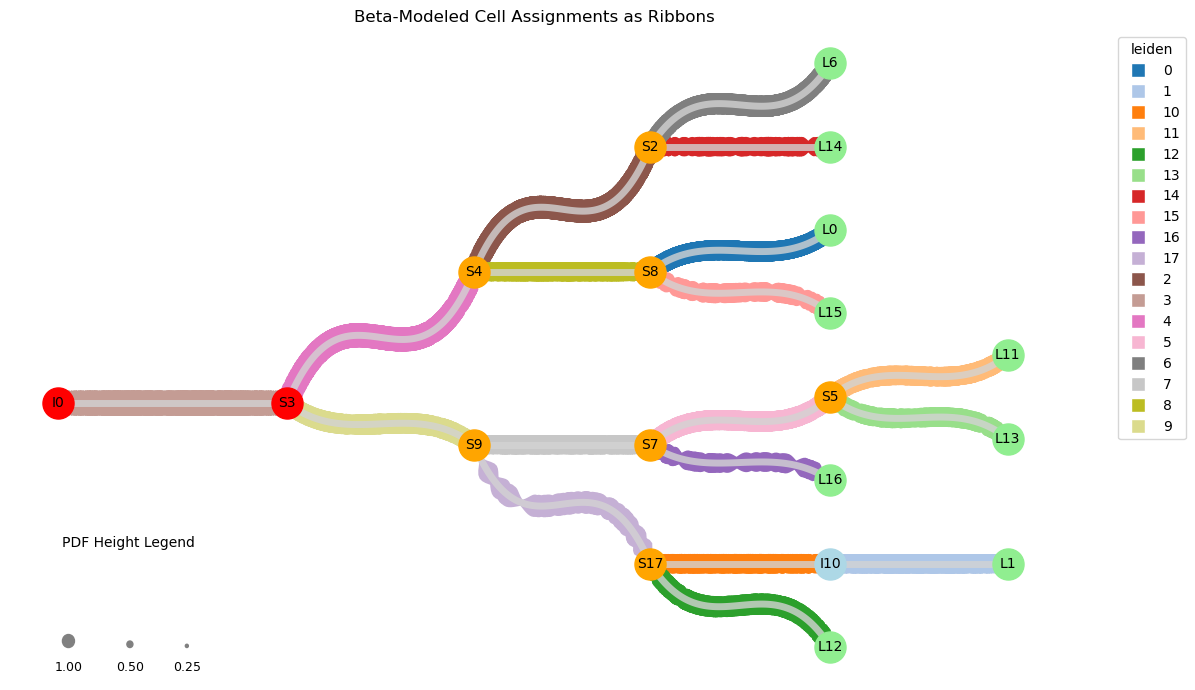

In [21]:
# Invert node_to_index to get index → name mapping
index_to_name = {v: k for k, v in traj_graph.node_to_index.items()}

# Convert index-based edges to name-based
fitted_betas["edge"] = fitted_betas["edge"].apply(
    lambda edge: (index_to_name[edge[0]], index_to_name[edge[1]])
)

from viz.trajectory import plot_pdf_width_ribbons_on_trajectory

plot_pdf_width_ribbons_on_trajectory(
    traj_graph,
    fitted_betas,
    adata,
    color_key="leiden",
    pdf_scale=.1,  # adjust if too narrow/wide
    curve_amount=0.8,
    title="Beta-Modeled Cell Assignments as Ribbons"
)


In [17]:
import torch
import numpy as np
import pandas as pd
from typing import Optional, Literal

# Import needed classes for type hinting (optional but good practice)
try:
    from models.posterior import TreeVariationalPosterior
    from models.trajectory import TrajectoryGraph 
    from anndata import AnnData
except ImportError:
    # Define dummy classes if imports fail, allowing function definition
    # In a real scenario, these imports should succeed in the notebook environment
    class TreeVariationalPosterior: pass
    class TrajectoryGraph: pass
    class AnnData: pass
    print("Warning: Could not import project classes. Using dummy types.")


def print_cell_expectations_by_cluster(
    posterior: TreeVariationalPosterior,
    adata: AnnData,
    cluster_key: str,
    traj_graph: Optional[TrajectoryGraph] = None, # Optional, primarily use posterior maps
    confidence_metric: Literal['max_prob', 'entropy'] = 'max_prob',
    top_n_cells: Optional[int] = 5,
    eps: float = 1e-8
):
    """
    Prints the expected edge, expected time, and confidence for cells, grouped by cluster.

    Calculates the most probable edge, the expected time (mean of Beta) on that edge,
    and a confidence score (either max edge probability or negative entropy of edge distribution).
    Results are grouped by the specified cluster key from adata.obs.

    Args:
        posterior: Trained TreeVariationalPosterior object. Must contain edge_logits,
                   alpha, beta parameters, and index_to_edge/index_to_name mappings.
        adata: AnnData object. Must contain cluster assignments in adata.obs[cluster_key].
               adata.obs_names must align with the cells in the posterior.
        cluster_key: The column name in adata.obs containing cluster labels.
        traj_graph: Optional TrajectoryGraph object (currently unused but could be for context).
        confidence_metric: How to measure confidence:
            'max_prob': Probability of the most likely edge (higher is better).
            'entropy': Negative entropy of the edge probability distribution (higher is better).
        top_n_cells: How many cells to print per cluster (sorted by confidence).
                     If None, prints all cells (can be very long).
        eps: Small epsilon for numerical stability (e.g., in log calculations).
    """
    # --- Input Validation ---
    if not isinstance(posterior, TreeVariationalPosterior):
        raise TypeError("`posterior` must be an instance of TreeVariationalPosterior")
    if not isinstance(adata, AnnData):
        raise TypeError("`adata` must be an instance of AnnData")
    if cluster_key not in adata.obs.columns:
        raise ValueError(f"Cluster key '{cluster_key}' not found in adata.obs.")
    if not hasattr(posterior, 'index_to_edge') or not hasattr(posterior, 'index_to_name'):
        raise AttributeError("Posterior object missing 'index_to_edge' or 'index_to_name' mapping.")

    device = posterior.device
    n_cells_posterior = posterior.n_cells
    n_cells_adata = adata.n_obs

    if n_cells_posterior != n_cells_adata:
        print(f"Warning: Posterior n_cells ({n_cells_posterior}) differs from adata.n_obs ({n_cells_adata}).")
        # Decide how to handle: error, use intersection, or assume first N match?
        # Let's assume the first n_cells_posterior match adata and proceed with caution.
        if n_cells_posterior > n_cells_adata:
            print("Using only the first {n_cells_adata} cells from the posterior.")
            n_cells = n_cells_adata
            adata_subset = adata
        else: # n_cells_adata > n_cells_posterior
             print(f"Using posterior's {n_cells_posterior} cells and corresponding AnnData entries.")
             n_cells = n_cells_posterior
             adata_subset = adata[:n_cells, :] # Slice adata to match posterior
    else:
        n_cells = n_cells_posterior
        adata_subset = adata
        
    cell_ids = adata_subset.obs_names

    # --- 1. Calculate Core Values from Posterior ---
    with torch.no_grad():
        # Edge probabilities
        edge_logits = posterior.edge_logits[:n_cells, :].detach()
        q_edge_probs = torch.softmax(edge_logits, dim=1) # [n_cells, n_edges]

        # Most probable edge index and its probability
        max_prob, edge_idx_max = torch.max(q_edge_probs, dim=1) # [n_cells], [n_cells]

        # Expected time on the most probable edge
        alpha_all = posterior.alpha[:n_cells, :].detach() # [n_cells, n_edges]
        beta_all = posterior.beta[:n_cells, :].detach()   # [n_cells, n_edges]
        cell_indices_gpu = torch.arange(n_cells, device=device)
        alpha_max = alpha_all[cell_indices_gpu, edge_idx_max] # [n_cells]
        beta_max = beta_all[cell_indices_gpu, edge_idx_max]   # [n_cells]
        expected_t = alpha_max / (alpha_max + beta_max + eps) # [n_cells]
        expected_t = expected_t.clamp(0.0, 1.0)

        # Calculate confidence score
        if confidence_metric == 'max_prob':
            confidence_score = max_prob
        elif confidence_metric == 'entropy':
            # Entropy = -sum(p * log(p)) -> Neg Entropy = sum(p * log(p))
            log_q_edge_probs = torch.log(q_edge_probs.clamp(min=eps))
            neg_entropy = torch.sum(q_edge_probs * log_q_edge_probs, dim=1)
            confidence_score = neg_entropy # Higher value (less negative/closer to 0) is higher confidence
        else:
            raise ValueError(f"Unknown confidence_metric: {confidence_metric}")

        # Move results to CPU
        edge_idx_max_np = edge_idx_max.cpu().numpy()
        expected_t_np = expected_t.cpu().numpy()
        confidence_score_np = confidence_score.cpu().numpy()

    # --- 2. Map Edge Indices to Names ---
    edge_names = []
    for edge_idx in edge_idx_max_np:
        try:
            u_idx, v_idx = posterior.index_to_edge[edge_idx]
            u_name = posterior.index_to_name.get(u_idx, f"Idx_{u_idx}") # Fallback name
            v_name = posterior.index_to_name.get(v_idx, f"Idx_{v_idx}") # Fallback name
            edge_names.append(f"{u_name} -> {v_name}")
        except KeyError:
            edge_names.append(f"Unknown Edge (Index: {edge_idx})")

    # --- 3. Aggregate Data ---
    cluster_labels = adata_subset.obs[cluster_key].astype(str).values # Ensure string type

    df_results = pd.DataFrame({
        'cell_id': cell_ids,
        'cluster': cluster_labels,
        'expected_edge': edge_names,
        'expected_time': expected_t_np,
        f'confidence ({confidence_metric})': confidence_score_np,
        # Keep index for sorting if needed later
        'original_index': np.arange(n_cells)
    })

    # --- 4. Group, Sort, and Print ---
    grouped = df_results.groupby('cluster')
    
    # Determine sort order based on confidence metric
    ascending_order = False # Higher score is better for both 'max_prob' and 'neg_entropy'

    print(f"\n--- Cell Expectations by Cluster ('{cluster_key}') ---")
    print(f"Confidence metric: {confidence_metric} (Higher value means higher confidence)")
    if top_n_cells is not None:
        print(f"Showing top {top_n_cells} cells per cluster, sorted by confidence.")
    else:
         print("Showing all cells per cluster, sorted by confidence.")
    print("-" * (len("--- Cell Expectations by Cluster () ---") + len(cluster_key) + 2))


    for cluster_name, group_df in grouped:
        print(f"\nCluster: {cluster_name} ({len(group_df)} cells)")
        
        # Sort within the group
        sorted_group = group_df.sort_values(
            by=f'confidence ({confidence_metric})', 
            ascending=ascending_order
        )

        # Select top N or all
        df_to_print = sorted_group.head(top_n_cells) if top_n_cells is not None else sorted_group

        if df_to_print.empty:
             print("  (No cells to display for this cluster)")
             continue

        # Determine max width for alignment (optional, improves readability)
        max_id_len = df_to_print['cell_id'].astype(str).map(len).max()
        max_edge_len = df_to_print['expected_edge'].astype(str).map(len).max()
        
        # Print header row
        header = (f"  {'Cell ID':<{max_id_len}}  {'Edge':<{max_edge_len}}  {'Time':<6}  {'Confidence':<10}")
        print(header)
        print("  " + "-" * (len(header)-2)) # Separator line
        
        # Print cell info
        for _, row in df_to_print.iterrows():
            conf_val = row[f'confidence ({confidence_metric})']
            # Format confidence based on metric type for readability
            if confidence_metric == 'max_prob':
                conf_str = f"{conf_val:.3f}" 
            else: # entropy (likely negative, closer to 0 is better)
                conf_str = f"{conf_val:.2f}"
                
            print(f"  {row['cell_id']:<{max_id_len}}  {row['expected_edge']:<{max_edge_len}}  {row['expected_time']:.3f}  {conf_str:<10}")

    print("\n--- End of Report ---")


# Example Usage (in a Jupyter Notebook cell after training):
# Assume 'trained_posterior', 'adata', and 'traj_graph' (optional) are available

print_cell_expectations_by_cluster(
    posterior=trained_posterior,
    adata=adata,
    cluster_key='leiden',  # Or your relevant cluster column name
    # traj_graph=traj_graph, # Optional
    confidence_metric='max_prob', # Or 'entropy'
    top_n_cells=10 # Show top 10 per cluster, or None for all
)


--- Cell Expectations by Cluster ('leiden') ---
Confidence metric: max_prob (Higher value means higher confidence)
Showing top 10 cells per cluster, sorted by confidence.
-----------------------------------------------

Cluster: 0 (860 cells)
  Cell ID           Edge                  Time    Confidence
  ----------------------------------------------------------
  TTGCGTCAGACGACGT  split_11 -> leaf_12   0.500  0.056     
  TGGGAAGTCGTCACAG  split_15 -> split_0   0.500  0.056     
  TCGGGACTCTTAGCCC  split_14 -> split_9   0.500  0.056     
  CGAGAAGGTTAGGGTG  split_15 -> split_14  0.500  0.056     
  ACTGTCCAGTCCGAAA  split_15 -> split_14  0.500  0.056     
  ACTGATGCAGCTATTG  split_11 -> leaf_12   0.500  0.056     
  ACTTTCACAGCGAACA  split_13 -> split_11  0.500  0.056     
  CTCGAGGGTAAGTGTA  split_14 -> int_7     0.500  0.056     
  CATCCACCATCCGCGA  split_13 -> split_6   0.500  0.056     
  TGGGAAGTCTTTCTTC  split_6 -> leaf_3     0.500  0.056     

Cluster: 1 (572 cells)
  Cell ID 

In [18]:
from scipy.stats import beta
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import networkx as nx
import pandas as pd

def plot_gene_dynamics_on_trajectory(
    G_traj, beta_assignments, adata, gene_name,
    resolution=100, curve_scale=1.0, blend_fraction=0.1,
    title="Gene Dynamics with Uncertainty"
):
    """
    Visualizes gene expression dynamics along trajectory edges while incorporating
    uncertainty from cell assignments. The tree structure is drawn first (nodes and
    straight edges). Over each edge, we compute for a set of t-values:
      - A weighted gene expression (which becomes the vertical offset from the base edge)
      - A weighted certainty (a proxy using each cell's beta PDF peak)
    
    The curve is drawn along the edge offset perpendicularly by the weighted expression
    (scaled by curve_scale). If the source node of an edge is a split, the first few points
    of the branch are blended with the parent's endpoint (source node position) using the 
    transition probability (attribute "A") from that edge.
    
    Args:
        G_traj: Trajectory graph (networkx.DiGraph or TrajectoryGraph object).
        beta_assignments (pd.DataFrame): Indexed by cell IDs with columns:
            'edge' (tuple of two node IDs), 'alpha', 'beta'.
        adata: AnnData-like object (for gene expression and cell IDs).
        gene_name (str): Gene to visualize (must be in adata.var_names).
        resolution (int): Number of t-values along each edge.
        curve_scale (float): Factor to scale the vertical offset of the curve.
        blend_fraction (float): Fraction of the curve (from t=0) to blend at split nodes.
        title (str): Plot title.
    """
    # If G_traj is a TrajectoryGraph, extract its underlying networkx graph.
    if hasattr(G_traj, 'G_traj'):
        G_traj = G_traj.G_traj

    # Compute node positions using graphviz layout.
    pos = nx.nx_agraph.graphviz_layout(G_traj, prog="dot", args="-Grankdir=LR")
    plt.figure(figsize=(12, 7))
    
    # Draw the tree structure: nodes and edges.
    for node, (x, y) in pos.items():
        plt.scatter(x, y, color='black', s=500, zorder=3)
        plt.text(x, y, node, fontsize=10, ha="center", va="center", zorder=4)
    for src, dst in G_traj.edges():
        if src not in pos or dst not in pos:
            continue
        P0, P1 = np.array(pos[src]), np.array(pos[dst])
        plt.plot([P0[0], P1[0]], [P0[1], P1[1]], color='lightgrey', lw=5, alpha=0.5, zorder=1)
    
    # Extract gene expression as a pandas Series (indexed by cell IDs).
    if gene_name in adata.var_names:
        gene_idx = adata.var_names.get_loc(gene_name)
        expr_array = (adata.X[:, gene_idx].toarray().ravel() 
                      if hasattr(adata.X, "toarray") 
                      else np.array(adata.X[:, gene_idx]).ravel())
        expr_series = pd.Series(expr_array, index=adata.obs_names)
    else:
        raise ValueError(f"Gene '{gene_name}' not found in adata.var_names")
    
    # Group cells by edge.
    # For each cell, compute its beta PDF along a grid of t-values.
    t_vals = np.linspace(0, 1, resolution)
    edge_groups = {}  # { edge: list of dicts for each cell }
    for cell_id, row in beta_assignments.iterrows():
        edge = row['edge']
        alpha_param = row['alpha']
        beta_param = row['beta']
        if not edge or alpha_param <= 0 or beta_param <= 0:
            continue
        # Compute beta PDF for this cell.
        pdf_vals = beta.pdf(t_vals, alpha_param, beta_param)
        pdf_vals = np.nan_to_num(pdf_vals)
        # Use the maximum of the PDF as a simple measure of certainty.
        cert = pdf_vals.max()
        if edge not in edge_groups:
            edge_groups[edge] = []
        edge_groups[edge].append({
            "cell_id": cell_id,
            "pdf": pdf_vals,
            "expr": expr_series.loc[cell_id],
            "cert": cert
        })
    
    # Prepare a colormap for certainty: blue = low, red = high.
    cmap = cm.RdBu_r

    # For each edge, compute the weighted gene expression and certainty along t.
    for edge, cells in edge_groups.items():
        src, dst = edge
        if src not in pos or dst not in pos:
            continue
        P0 = np.array(pos[src])
        P1 = np.array(pos[dst])
        direction = P1 - P0
        seg_length = np.linalg.norm(direction)
        if seg_length == 0:
            continue
        direction = direction / seg_length
        # Compute a perpendicular (normal) vector.
        normal = np.array([-direction[1], direction[0]])
        
        # Initialize accumulators for weighted expression and certainty.
        weighted_expr = np.zeros_like(t_vals, dtype=float)
        weighted_cert = np.zeros_like(t_vals, dtype=float)
        weight_sum = np.zeros_like(t_vals, dtype=float)
        
        for cell in cells:
            pdf_vals = cell["pdf"]
            weighted_expr += cell["expr"] * pdf_vals
            weighted_cert += cell["cert"] * pdf_vals
            weight_sum += pdf_vals
        
        mask = weight_sum > 0
        weighted_expr[mask] /= weight_sum[mask]
        weighted_cert[mask] /= weight_sum[mask]
        
        # Compute the base curve along the edge.
        base_curve = np.array([P0 + t * (P1 - P0) for t in t_vals])
        # Offset the base curve by the weighted expression along the normal,
        # scaling the offset by curve_scale.
        curve_pts = base_curve + np.outer(weighted_expr * curve_scale, normal)
        
        # If the source node is a split, blend the first few points with the parent's endpoint.
        # We assume that a split node is identified by its type attribute containing "split".
        if "split" in G_traj.nodes[src].get("type", ""):
            # Get the transition probability for this edge (default to 1 if not defined)
            A = G_traj.edges[src, dst].get("A", 1.0)
            # Blend the first blend_count points.
            blend_count = max(2, int(blend_fraction * resolution))
            for i in range(blend_count):
                blend_weight = A * (i / blend_count)  # gradually ramp from 0 to A
                # Blend parent's endpoint (P0) and the computed branch start.
                curve_pts[i] = (1 - blend_weight) * P0 + blend_weight * curve_pts[i]
        
        # Normalize certainty values for color mapping.
        cert_min, cert_max = weighted_cert.min(), weighted_cert.max()
        if cert_max > cert_min:
            norm_cert = (weighted_cert - cert_min) / (cert_max - cert_min)
        else:
            norm_cert = np.full_like(weighted_cert, 0.5)
        
        # Draw the curve as a series of short segments colored by certainty.
        for i in range(resolution - 1):
            seg_x = curve_pts[i:i+2, 0]
            seg_y = curve_pts[i:i+2, 1]
            seg_color = cmap(norm_cert[i])
            plt.plot(seg_x, seg_y, color=seg_color, lw=2, zorder=2)
    
    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


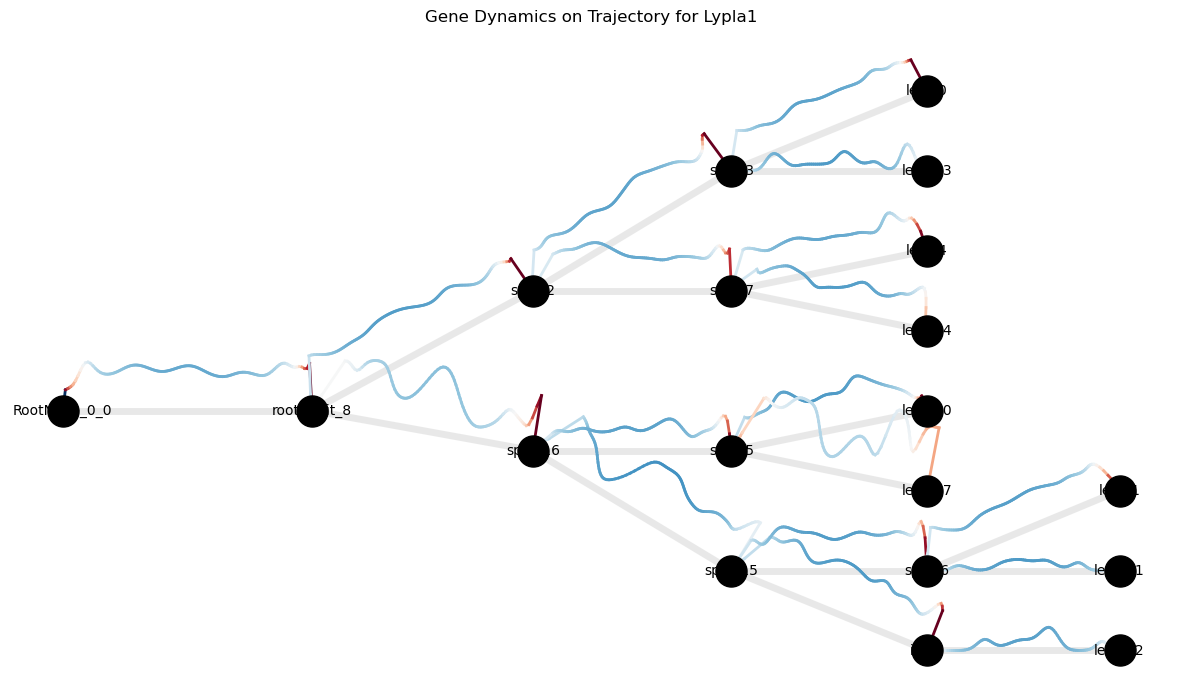

In [19]:
plot_gene_dynamics_on_trajectory(traj_graph, beta_assignments, adata, gene_name='Lypla1',
                                 resolution=100, curve_scale=100.0, blend_fraction=0.1,
                                 title="Gene Dynamics on Trajectory for Lypla1")